# TP GSE - Valentin MESSINA

Nous mettons en oeuvre dans ce notebook certains des éléments vus en séance concernant l'utilisation de Générateurs de Scénarios Economiques (GSE) dans la mesure monde réelle en assurance. 

Nous considérons une compagnie d'assurance qui souhaite investir les primes qu'elle perçoit dans un fond assimilable à un indice action ainsi que dans des obligations. 

En équation, la valeur du portefeuille à tout moment $t$ s'écrira de la manière suivante : 
$$
P_t = \alpha S_t + (1- \alpha) e^{\int_0^t r_u \text{d}u}
$$

où $S_t$ est la valeur de l'indice action à la date $t$ et $P(t,T)$ est le prix en date $t$ d'un Zéro-Coupon expirant en date $T \geq t$, $\alpha$ et $1-\alpha$  sont les pondérations associés aux rendements de chaque sous-jacent. La compagnie souhaite mener une étude d'allocation optimale de son portefeuille d'investissement et ainsi qu'une étude de risque de solvabilité, liée à l'allocation finale retenue. Pour ce faire, l'assurance recourt à un GSE Monde-Réel qui produira des simulations de trajectoires de l'indice action $S$ et des Zéro-Coupons de maturité $M$. Grâce à ces simulations, il sera possible de simuler différents scénarios de valeur pour le portefeuille de l'assureur, en fonction du poids $\alpha$ retenu.

<b> Le but final de ce TP est de construire un GSE mesure Monde-Réelle permettant de déduire l'allocation optimale entre fond obligataire et action ; cela passe donc par un calibrage des modèles qui le composent, leur simulation puis la validation des trajectoires simulées

--------------------------------------------------------------------------------------------------------------
## <ins>Description des modèles</ins>

Le GSE est constitué de deux modèles : l'un permettant la simulation de trajectoires de taux (pour calculer des prix Zéro-Coupon *in fine*), le second permettant la simulation de trajectoires actions.

#### 1. <ins> Modèle de taux : le **G2++** (*2-factor Gaussian*) <ins>

##### Spécification risque neutre

Nous choisissons un modèle de taux court dans lequel l'évolution du taux court non risqué $r$ est donnée par l'équation suivante : 
$$
    r_t = x_t + y_t + \varphi(t) \\
$$

Nous commençons par exprimer la dynamique du taux court dans l'univers risque neutre. Nous voulons l'exprimer en monde réel dans la suite.

$$
    \text{d} x_t = - a_1 x_t \text{d} t + \sigma_1 \text{d} \widetilde{W}^1_t \\
    \text{d} y_t = - a_2 y_t \text{d} t + \sigma_2 \text{d} \widetilde{W}^2_t
$$
où : 
* $\widetilde{W}^1$ et $\widetilde{W}^2$ sont deux mouvements brownians sous la mesure risque neutre $\mathbb{P}^*$, **corrélés**, tels que $\langle\widetilde{W}^1, \widetilde{W}^2 \rangle_t= \rho t$, avec $\rho \in [-1, 1]$,
* $a_1,a_2,\sigma_1, \sigma_2$ sont des **paramètres positifs**, 
* $t \mapsto \varphi(t)$ est une fonction déterministe et continue du temps permettant de **reproduire la structure à terme initiale**.

##### Expression des prix Zéro-Coupon
Dans ce modèle de taux court, le déflateur entre les dates $s$ et $t$ ($s \leq t$) se calcule comme :
$$
    D(s,t) = \exp \Big( - \int_s^t r_u \text{d} u \Big).
$$

En notant $\mathcal{F}_t$ la filtration générée par le processus de taux court $r$ jusqu'à la date $t$, on montre également que le **prix d'un Zéro-Coupon à la date $t$, de maturité $T$, s'exprime dans ce modèle** avec la formule théorique suivante : 
 $$
    P^{\text{Mod}}(t, T ; a_1,a_2,\sigma_1, \sigma_2)=\mathbb{E}^*[D(t, T) | \mathcal{F}_t] = \exp \Big( -\int_t^T{\varphi(u)du} - B(T - t;a_1) x_t - B(T - t;a_2) y_t - \frac{1}{2} A(T - t;a_1,a_2,\sigma_1, \sigma_2, \rho) \Big),
 $$

 où : 

 * $A(\tau;a_1,a_2,\sigma_1, \sigma_2, \rho) = \sum_{i=1}^2\frac{\sigma_i^2}{a_i^2} \Big( \tau + \frac{2}{a_i} e^{-a_i\tau} - \frac{e^{-2a_i\tau}}{2 a_i} - \frac{3}{2 a_i} \Big) \Big) + 2 \rho \frac{\sigma_1 \sigma_2}{a_1 a_2} \big( \tau - B(\tau;a_1) - B(\tau;a_2) + B(\tau;a_1+a_2) \big)$ ,
 * $B(\tau;a) = \frac{1-e^{-a\tau}}{a}$.

##### Passage en univers monde réel
Nous écrivons les formules de passage suivantes:
$$
    d\widetilde{W}^i_t = dW^i_t + \gamma_i d t, i = 1, 2
$$
où :
* $\gamma_i, i = 1, 2$ sont deux paramètres constants, permettant la définition des mouvements browniens sous la probabilité monde réelle. Ils sont aussi notées **primes de risque**.
* $W^1$ et $W^2$ sont deux mouvements Browniens sous la mesure monde réelle $\mathbb{P}$. Nous avons aussi $\langle{W}^1, {W}^2 \rangle_t= \rho t$.

Ainsi, nous pouvons exprimer la dynamique du modèle dans l'univers monde réel :
$$
r_t = x_t + y_t + \varphi(t) \\
\text{d} x_t = - a_1 x_t \text{d} t + \sigma_1 \gamma_1 \text{d} t + \sigma_1 \text{d} W^1_t \\
\text{d} y_t = - a_2 y_t \text{d} t + \sigma_2 \gamma_2 \text{d} t + \sigma_2 \text{d} W^2_t
$$

#### 2. <ins> Modèle action <ins>

Nous choisissons de représenter l'évolution de l'indice action selon la dynamique 
$$
\text{d} S_t = S_t \left(\mu \text{d} t + \sigma \text{d} B_t \right), S_0 = 1
$$
    
où : 
* $B$ est un mouvement Brownien corrélé à $W^1$ et $W^2$,
* $S$ représente la valeur de l'indice action.

--------------------------------------------------------------------------------------------------------------
### Question 1 (2 pt) : 

Afin de justifier la la formule du prix Zéro-Coupon, nous souhaitons expliciter la loi de la variable aléatoire $ ( - \int_t^T r_u \text{d} u )$.

En utilisant la spécification risque neutre, pour tout $T \geq t \geq 0$, **justifier** les expressions suivantes :
$$ 
x_T = x_t e^{- a_1 (T-t)} + \sigma_1 \int_t^T e^{- a_1 (T-u)} \text{d} \widetilde{W}^1_u, \\
y_T = y_t e^{- a_2 (T-t)} + \sigma_2 \int_t^T e^{- a_2 (T-u)} \text{d} \widetilde{W}^2_u.
$$

**En déduire** que :

$$ 
\int_t^T x_u \text{d} u = x_t B(t,T;a_1) + \sigma_1 \int_t^T B(u,T;a_1) \text{d} \widetilde{W}^1_u, \\
\int_t^T y_u \text{d} u = y_t B(t,T;a_2) + \sigma_2 \int_t^T B(u,T;a_2) \text{d} \widetilde{W}^2_u, \\
$$

**Conclure** que la loi de  $(- \int_t^T r_u \text{d} u )$ conditionnellement à $\mathcal{F}_t$ est une loi normale:
* de moyenne :
$$
    m_t = - \int_t^T \varphi(u)du - B(t,T;a_1) x_t - B(t,T;a_2) y_t
$$
* de variance :
$$
    v_t = \sum_{i=1}^2 \sigma_i^2 \int_t^T B(t,T;a_i)^2 \text{d} u + 2 \sigma_1 \sigma_2 \rho \int_t^T B(t,T;a_1) B(t,T;a_2) \text{d} u
$$

La formule théorique du prix Zéro-Coupon est ensuite obtenue en explicitant les calculs des intégrales ci-dessus, et en calculant $\mathbb{E}^*[e^{- \int_t^T r_u \text{d} u} | \mathcal{F}_t]$ comme une transformée de Laplace d'une loi normale.

--------------------------------------------------------------------------------------------------------------

#### Justification des expressions données :

On multiplie l'équation 1 par $e^{a_1t}$ et l'équation 2 par $e^{a_2t}$ : 

$$
e^{a_1t}\text{d} x_t = - a_1 e^{a_1t}x_t \text{d} t + \sigma_1 e^{a_1t}d\widetilde{W}^1_t \\
e^{a_2t}\text{d} y_t = - a_2 e^{a_2t}y_t \text{d} t + \sigma_2 e^{a_2t}d\widetilde{W}^2_t
$$

Ce qui donne en regroupant :

$$
e^{a_1t}\text{d} x_t + a_1 e^{a_1t}x_t \text{d} t = \sigma_1 e^{a_1t}d\widetilde{W}^1_t \\
e^{a_2t}\text{d} y_t + a_2 e^{a_2t}y_t \text{d} t = \sigma_2 e^{a_2t}d\widetilde{W}^2_t
$$

On remarque notamment que $e^{a_1t}\text{d} x_t + a_1 e^{a_1t}x_t \text{d} t = \text{d}(e^{a_1t}x_t)$, d'où :

$$
\text{d}(e^{a_1t}x_t) = \sigma_1 e^{a_1t}d\widetilde{W}^1_t \\
\text{d}(e^{a_2t}y_t) = \sigma_2 e^{a_2t}d\widetilde{W}^2_t
$$

On intègre alors entre $t$ et $T$ ce qui donne :

$$
e^{a_1T}x_T - e^{a_1t}x_t = \sigma_1 \int_t^T e^{a_1u}d\widetilde{W}^1_u \\
e^{a_2T}y_T - e^{a_2T}y_t = \sigma_2 \int_t^T e^{a_2u}d\widetilde{W}^2_u
$$

Il ne reste plus qu'à diviser l'équation 1 par $e^{a_1T}$ et l'équation 2 par $e^{a_2T}$, ce qui donne le résultat :

$$ 
x_T = x_t e^{- a_1 (T-t)} + \sigma_1 \int_t^T e^{- a_1 (T-u)} \text{d} \widetilde{W}^1_u \\
y_T = y_t e^{- a_2 (T-t)} + \sigma_2 \int_t^T e^{- a_2 (T-u)} \text{d} \widetilde{W}^2_u
$$

#### Déduction des valeurs des intégrales :

On sait que : 

$dx_t + a_1 x_t dt = \sigma_1 d\widetilde{W}^1_t$, c'est-à-dire :  $x_t dt = -\frac{1}{a_1} dx_t - \frac{1}{a_1} \sigma_1 d\widetilde{W}^1_t$


On intègre cette expression entre $t$ et $T$ ce qui donne :

  $$
  \int_t^T x_u du = -\frac{1}{a_1} (x_T - x_t) - \frac{1}{a_1} \int_t^T \sigma_1 d\widetilde{W}^1_u
  $$

On utilise alors l'expression de $x_T$ trouvée précédemment :

  $$
  \begin{aligned}
    \int_t^T x_u du &= -\frac{1}{a_1} \bigg(x_T e^{-a_1(T-t)} + \sigma_1 \int_t^T e^{-a_1(T-u)} d\widetilde{W}^1_u - x_t \bigg) + \frac{1}{a_1} \int_t^T \sigma_1 d\widetilde{W}^1_u \\
    \int_t^T x_u du &= \frac{1 - e^{-a_1(T-t)}}{a_1} x_t + \sigma_1 \int_t^T \frac{1 - e^{-a_1(T-u)}}{a_1} d\widetilde{W}^1_u
  \end{aligned}
  $$

On identifie alors les expressions de  $B(u; T, a_1) = B(T - u; a_1) = \frac{1 - e^{-a_1(T-u)}}{a_1}$. D'où :

  $$
  \int_t^T x_u du = x_t B(t; T, a_1) + \sigma_1 \int_t^T B(u; T, a_1) d\widetilde{W}^1_u
  $$

De façon analogue, on montre que :

  $$
  \int_t^T y_u du = y_t B(t; T, a_2) + \sigma_2 \int_t^T B(u; T, a_2) d\widetilde{W}^2_u.
  $$
  
#### Conclusion sur la loi de $(- \int_t^T r_u \text{d} u )$ conditionnellement à $\mathcal{F}_t$ :

$$
    r_t = x_t + y_t + \varphi(t) 
$$
Donc par intégration, on obtient :
$$
\bigg(- \int_t^T r_u \text{d} u \bigg) = -\int_t^T x_u du - \int_t^T y_u du  -  \int_t^T \varphi(u) du 
$$

D'abord, il est clair que $\bigg(- \int_t^T r_u \text{d} u \bigg)$ conditionnellement à $\mathcal{F}_t$ suit une loi normale car c'est une somme de variables qui suivent des lois normales (l'intégrale d'un mouvement brownien est gaussienne). Calculons donc sa moyenne et sa variance.

On sait que 
$\sigma_1 \int_t^T B(u; T, a_1) d\widetilde{W}^1_u $ et $\sigma_2 \int_t^T B(u; T, a_2) d\widetilde{W}^2_u.$ sont indépendants de $\mathcal{F_t}$. 

On projette alors sur $\mathcal{F_t}$ :
$$
    m_t = - \int_t^T \varphi(u)du - B(t,T;a_1) x_t - B(t,T;a_2) y_t
$$


Pour calculer la variance conditionnelle de $- \int_t^T r_u \, \text{d} u$ sachant $\mathcal{F}_t$, où $r_u = x_u + y_u + \varphi(u)$ et $\varphi(u)$ est une fonction déterministe de $u$ donc de variance nulle.

Ensuite, on développe la variance de la somme  :

$$
\text{Var}\left(- \int_t^T r_u \, \text{d} u \, \bigg| \, \mathcal{F}_t\right) = \text{Var}\left(- \int_t^T x_u \, \text{d} u \, \bigg| \, \mathcal{F}_t\right) + \text{Var}\left(- \int_t^T y_u \, \text{d} u \, \bigg| \, \mathcal{F}_t\right) + 2\text{Cov}\left(- \int_t^T x_u \, \text{d} u, - \int_t^T y_u \, \text{d} u \, \bigg| \, \mathcal{F}_t\right)
$$

On utilise l'indépendance des browniens avec $\mathcal{F_t}$ pour ne calculer que des variances non conditionnelles et on conclut à l'aide l'isométrie d'Itô.

$$
\text{Var}\left(- \int_t^T x_u \, \text{d} u \, \bigg| \, \mathcal{F}_t\right)= \text{Var}\left(- \int_t^T x_u \, \text{d} u\right) = \sigma_1^2 \int_t^T B(u,T;a_1)^2 \, \text{d} u
$$

$$
\text{Var}\left(- \int_t^T y_u \, \text{d} u \, \bigg| \, \mathcal{F}_t\right) = \text{Var}\left(- \int_t^T y_u \, \text{d} u \right) = \sigma_2^2 \int_t^T B(u,T;a_2)^2 \, \text{d} u
$$

De même : 

$$
\text{Cov}\left(- \int_t^T x_u \, \text{d} u, - \int_t^T y_u \, \text{d} u \, \bigg| \, \mathcal{F}_t\right) = \text{Cov}\left(- \int_t^T x_u \, \text{d} u, - \int_t^T y_u \, \text{d} u \right) = \rho \, \sigma_1 \sigma_2 \int_t^T B(u,T;a_1) B(u,T;a_2) \, \text{d} u
$$

Finalement, on retrouve bien le résultat annoncé :
$$
    v_t = \sum_{i=1}^2 \sigma_i^2 \int_t^T B(t,T;a_i)^2 \text{d} u + 2 \sigma_1 \sigma_2 \rho \int_t^T B(t,T;a_1) B(t,T;a_2) \text{d} u
$$

--------------------------------------------------------------------------------------------------------------
### Question 2 (1 pt) : 

Nous souhaitons choisir la fonction $\varphi$ afin de répliquer exactement la courbe initiale de marché $(P^{Mkt}(0, T))_{T=T_1, \dots, T_N}$, càd assurer que :
$$ 
    \forall T = T_1, \dots, T_N, P^{Mod}(0, T) = P^{Mkt}(0, T).
$$

En utilisant la formule théorique du prix Zéro-Coupon, **exprimer** le prix initial $P^{Mod}(0, T)$ et **calculer** $\frac{\partial \log(P^{Mod}(0, T))}{\partial T}$.

**En déduire** que $\varphi$ peut-être choisie comme :

$$
    \forall T \geq 0, \varphi(T) = - \frac{\partial \log(P^{Mkt}(0, T))}{\partial T} + \sum_{i=1}^2 \frac{\sigma_i^2}{2 a_i^2} (1-e^{-a_i T})^2   + \rho \frac{\sigma_1 \sigma_2}{a_1 a_2} (1-e^{-a_1 T})(1-e^{-a_2 T}).
$$

--------------------------------------------------------------------------------------------------------------

#### Expression du prix initial par la formule théorique du prix ZC 

D'après le cours :
$$
P^{\text{Mod}}(0, T ; a_1, a_2, \sigma_1, \sigma_2) = \exp \left( -\int_0^T{\varphi(u) \, \text{d}u} - B(T;a_1) x_0 - B(T;a_2) y_0 - \frac{1}{2} A(T;a_1, a_2, \sigma_1, \sigma_2, \rho) \right),
$$

où $x_0$ et $y_0$ sont les valeurs initiales des processus $x_t$ et $y_t$ et les fonctions $B(\tau; a)$ et $A(\tau; a_1, a_2, \sigma_1, \sigma_2, \rho)$ sont définies par :

$$
B(T; a_i) = \frac{1 - e^{-a_i T}}{a_i},
$$

et

$$
A(T; a_1, a_2, \sigma_1, \sigma_2, \rho) = \sum_{i=1}^2 \frac{\sigma_i^2}{a_i^2} \left( T + \frac{2}{a_i} e^{-a_i T} - \frac{e^{-2 a_i T}}{2 a_i} - \frac{3}{2 a_i} \right) + 2 \rho \frac{\sigma_1 \sigma_2}{a_1 a_2} \left( T - B(T; a_1) - B(T; a_2) + B(T; a_1 + a_2) \right).
$$

#### Calcul de la dérivée partielle

On a juste à dériver la quantité précédente par rapport à $T$ :


$$
\frac{\partial \log(P^{\text{Mod}}(0, T))}{\partial T} = -\varphi(T) - \frac{\partial B(T;a_1)}{\partial T} x_0 - \frac{\partial B(T;a_2)}{\partial T} y_0 - \frac{1}{2} \frac{\partial A(T;a_1, a_2, \sigma_1, \sigma_2, \rho)}{\partial T},
$$

Avec :
$$
\frac{\partial B(T;a_i)}{\partial T} =  e^{-a_iT},
$$

ainsi que :

$$
\frac{\partial A}{\partial T} = \frac{\sigma_1^2 \left(1 - 2e^{-T a_1} + e^{-2T a_1}\right)}{a_1^2} + \frac{\sigma_2^2 \left(1 - 2e^{-T a_2} + e^{-2T a_2}\right)}{a_2^2} + 2\rho\frac{\sigma_1 \sigma_2 \left(e^{-T(a_1 + a_2)} + 1 - e^{-T a_2} - e^{-T a_1}\right)}{a_1 a_2}.
$$

#### Déduction du choix de $\varphi$

On a : 

$$ 
    \forall T \geq 0, \frac{\partial \log(P^{\text{Mod}}(0, T))}{\partial T} = \frac{\partial \log(P^{\text{Mkt}}(0, T))}{\partial T}.
$$

Ce qui nous permet facilement d'isoler $\varphi$ : 

$$
    \forall T \geq 0, \varphi(T) = - \frac{\partial \log(P^{Mkt}(0, T))}{\partial T} + \sum_{i=1}^2 \frac{\sigma_i^2}{2 a_i^2} (1-e^{-a_i T})^2   + \rho \frac{\sigma_1 \sigma_2}{a_1 a_2} (1-e^{-a_1 T})(1-e^{-a_2 T}).
$$

## <ins>Implémentation</ins>

In [1]:
# importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

### <ins>Données à disposition pour le calibrage</ins> 

L'univers de modélisation étant celui du monde réel, le calibrage des modèles nécéssite des historiques de données. Ces données sont à présents fournies, elles sont composées : 
* D'une courbe de taux de maturités allant de 1 à 120 ans  ; 
* D'un historique de données de taux swaps de maturité 1 an, 5 ans, et 10 ans ; 
* D'un historique des valeurs d'une indice action dont on souhaite répliquer le comportement.

In [2]:
donnees_marche = pd.DataFrame(
    {
        # Courbe de taux Zéro-Coupon
        'Maturites taux': range(1,121),
        'ZCR': [0.05289, 0.04455, 0.04143, 0.04075, 0.04209, 0.03970, 0.03959, 0.03944, 0.03954, 0.04196, 0.03971, 0.03990, 0.03951, 0.04023, 0.03970, 0.04045, 0.04024, 0.03964, 0.03976, 0.04003, 0.03992, 0.03983, 0.03918, 0.03857, 0.03878, 0.03857, 0.03763, 0.03818, 0.03782, 0.03704, 0.03683, 0.03661, 0.03612, 0.03663, 0.03608, 0.03596, 0.03633, 0.03614, 0.03546, 0.03583, 0.03527, 0.03602, 0.03577, 0.03587, 0.03505, 0.03538, 0.03523, 0.03512, 0.03566, 0.03538, 0.03489, 0.03519, 0.03474, 0.03559, 0.03510, 0.03529, 0.03519, 0.03506, 0.03539, 0.03519, 0.03520, 0.03485, 0.03513, 0.03513, 0.03485, 0.03458, 0.03542, 0.03544, 0.03529, 0.03498, 0.03522, 0.03511, 0.03503, 0.03501, 0.03448, 0.03535, 0.03512, 0.03527, 0.03501, 0.03475, 0.03506, 0.03469, 0.03528, 0.03482, 0.03469, 0.03462, 0.03463, 0.03482, 0.03466, 0.03434, 0.03503, 0.03457, 0.03465, 0.03510, 0.03482, 0.03514, 0.03521, 0.03505, 0.03445, 0.03454, 0.03448, 0.03428, 0.03445, 0.03476, 0.03510, 0.03430, 0.03476, 0.03470, 0.03439, 0.03465, 0.03439, 0.03450, 0.03438, 0.03460, 0.03483, 0.03491, 0.03462, 0.03514, 0.03484, 0.03425]
    }
)

delta_hist = 1/12

donnees_histo = pd.DataFrame(
    {
        'Dates': pd.date_range(start='1998-10-31',  freq='M', periods=302),
        'Action': [1.00000, 1.02104, 1.14623, 1.16771, 1.12596, 1.14737, 1.23074, 1.17108, 1.29307, 1.23770, 1.22319, 1.19295, 1.25050, 1.28709, 1.30388, 1.29188, 1.26785, 1.29072, 1.31920, 1.30407, 1.27769, 1.33934, 1.35120, 1.23981, 1.27477, 1.17307, 1.23861, 1.23394, 1.11620, 1.06315, 1.09263, 1.14762, 1.11684, 1.11064, 1.03684, 0.90641, 0.96269, 1.00810, 1.07791, 1.01597, 0.95507, 0.99089, 0.97196, 0.92533, 0.87619, 0.84019, 0.81963, 0.74065, 0.80423, 0.81743, 0.83103, 0.78128, 0.79183, 0.76547, 0.79065, 0.85724, 0.86283, 0.89174, 0.91720, 0.91741, 0.91838, 0.98054, 1.04277, 1.05722, 1.02160, 1.02748, 1.00426, 0.99458, 1.05971, 1.01214, 1.01439, 1.05152, 0.97958, 1.04015, 1.05213, 1.07554, 1.12571, 1.05831, 1.03616, 1.03967, 1.07433, 1.12228, 1.07331, 1.12728, 1.13577, 1.09082, 1.08785, 1.10302, 1.14608, 1.17979, 1.21968, 1.19253, 1.16049, 1.12105, 1.19479, 1.14931, 1.27431, 1.28573, 1.28312, 1.35783, 1.29212, 1.29326, 1.27671, 1.41660, 1.30329, 1.31155, 1.38320, 1.32912, 1.39159, 1.37267, 1.35168, 1.25500, 1.25310, 1.21335, 1.29567, 1.31693, 1.17155, 1.13865, 1.10412, 1.02591, 0.88194, 0.81479, 0.78976, 0.72801, 0.68113, 0.73602, 0.76540, 0.79538, 0.80025, 0.88689, 0.96010, 0.99406, 0.93707, 1.03423, 0.98795, 0.95457, 1.03553, 1.05243, 1.08619, 0.99689, 0.97328, 0.98884, 0.92130, 1.01256, 1.04264, 1.06561, 1.10700, 1.20865, 1.23698, 1.15346, 1.27196, 1.25557, 1.15124, 1.20082, 1.07831, 0.99503, 1.14117, 1.08043, 1.10013, 1.21852, 1.19573, 1.31768, 1.25559, 1.14373, 1.26839, 1.23850, 1.30735, 1.30103, 1.24910, 1.29697, 1.28883, 1.32493, 1.33612, 1.43210, 1.41212, 1.40471, 1.46706, 1.46253, 1.51351, 1.45559, 1.62423, 1.64822, 1.59489, 1.58901, 1.59759, 1.68935, 1.75639, 1.75219, 1.82991, 1.81840, 1.83561, 1.74721, 1.80512, 1.89727, 1.80163, 1.73082, 1.84324, 1.77748, 1.86006, 1.87464, 1.90052, 1.93713, 1.78521, 1.70818, 1.81254, 1.91498, 1.79650, 1.82733, 1.76349, 1.80588, 1.84253, 1.90511, 1.87446, 1.90825, 1.91578, 1.94478, 1.84102, 1.92310, 2.09865, 2.09641, 2.07805, 2.05445, 2.06428, 2.26602, 2.17384, 2.31615, 2.15026, 2.28795, 2.28217, 2.49494, 2.30245, 2.62832, 2.48048, 2.38293, 2.31343, 2.53301, 2.44592, 2.49880, 2.55409, 2.50274, 2.33516, 2.44824, 2.19422, 2.32775, 2.52945, 2.63281, 2.64718, 2.41290, 2.61542, 2.69604, 2.53835, 2.78589, 2.60643, 2.81806, 2.83438, 2.88146, 2.72923, 2.25858, 2.68134, 2.80268, 2.65932, 2.81490, 3.04989, 2.95314, 2.96456, 3.14054, 3.29260, 3.44759, 3.32750, 3.43607, 3.93719, 3.60696, 3.87971, 4.05868, 4.12949, 3.69823, 4.19096, 4.07110, 4.44901, 4.02260, 4.06134, 4.26024, 3.85738, 3.56384, 3.33824, 3.61143, 3.47968, 3.30935, 3.57851, 3.72599, 3.57740, 3.71569, 3.65893, 3.74574, 3.89554, 3.89616, 3.91983, 4.10845, 3.88904, 3.99035, 3.86014, 3.95258],
        'Taux 1A': [0.04663, 0.04959, 0.04999, 0.05029, 0.05334, 0.05163, 0.05190, 0.05445, 0.05786, 0.05789, 0.05875, 0.05886, 0.06193, 0.06159, 0.06390, 0.06641, 0.06603, 0.06702, 0.06959, 0.07205, 0.06951, 0.06906, 0.06734, 0.06573, 0.06515, 0.06334, 0.05798, 0.05128, 0.04847, 0.04585, 0.04400, 0.04178, 0.04209, 0.03756, 0.03625, 0.02756, 0.02359, 0.02374, 0.02445, 0.02470, 0.02472, 0.03112, 0.02640, 0.02679, 0.02333, 0.02042, 0.01963, 0.01653, 0.01670, 0.01711, 0.01467, 0.01487, 0.01449, 0.01310, 0.01384, 0.01241, 0.01173, 0.01352, 0.01529, 0.01243, 0.01563, 0.01673, 0.01462, 0.01563, 0.01436, 0.01352, 0.01862, 0.02913, 0.02397, 0.02425, 0.02313, 0.02571, 0.02580, 0.02940, 0.03042, 0.03235, 0.03564, 0.03755, 0.03657, 0.03720, 0.03874, 0.04170, 0.04102, 0.04480, 0.04642, 0.04706, 0.04741, 0.04900, 0.05067, 0.05158, 0.05217, 0.05314, 0.05545, 0.05469, 0.05329, 0.05255, 0.05227, 0.05167, 0.05214, 0.05304, 0.05167, 0.05201, 0.05249, 0.05347, 0.05373, 0.05181, 0.04955, 0.04664, 0.04563, 0.04241, 0.04095, 0.02753, 0.02604, 0.02336, 0.02902, 0.03014, 0.03105, 0.03012, 0.03030, 0.03306, 0.02434, 0.02078, 0.01296, 0.01272, 0.01439, 0.01259, 0.01165, 0.00919, 0.00972, 0.00869, 0.00665, 0.00662, 0.00674, 0.00547, 0.00696, 0.00574, 0.00561, 0.00633, 0.00664, 0.01324, 0.00773, 0.00539, 0.00467, 0.00452, 0.00448, 0.00620, 0.00529, 0.00461, 0.00433, 0.00553, 0.00423, 0.00445, 0.00454, 0.00496, 0.00539, 0.00570, 0.00622, 0.00616, 0.00729, 0.00553, 0.00576, 0.00584, 0.00586, 0.00597, 0.00579, 0.00420, 0.00429, 0.00419, 0.00372, 0.00411, 0.00379, 0.00417, 0.00351, 0.00358, 0.00365, 0.00346, 0.00397, 0.00352, 0.00396, 0.00318, 0.00377, 0.00289, 0.00394, 0.00303, 0.00293, 0.00300, 0.00302, 0.00303, 0.00381, 0.00404, 0.00352, 0.00418, 0.00405, 0.00396, 0.00540, 0.00445, 0.00498, 0.00510, 0.00474, 0.00549, 0.00513, 0.00623, 0.00618, 0.00553, 0.00633, 0.00723, 0.00916, 0.00751, 0.00824, 0.00799, 0.00788, 0.00911, 0.00674, 0.00853, 0.00960, 0.00975, 0.01010, 0.01171, 0.01231, 0.01255, 0.01361, 0.01452, 0.01473, 0.01378, 0.01525, 0.01523, 0.01498, 0.01557, 0.01629, 0.01865, 0.01969, 0.02172, 0.02374, 0.02478, 0.02538, 0.02526, 0.02639, 0.02671, 0.02658, 0.02832, 0.02879, 0.02922, 0.02741, 0.02678, 0.02680, 0.02605, 0.02590, 0.02307, 0.02047, 0.02189, 0.01861, 0.01853, 0.01743, 0.01748, 0.01816, 0.01543, 0.01191, 0.00754, 0.00433, 0.00342, 0.00270, 0.00290, 0.00257, 0.00230, 0.00303, 0.00232, 0.00258, 0.00246, 0.00241, 0.00291, 0.00256, 0.00155, 0.00279, 0.00197, 0.00174, 0.00172, 0.00360, 0.00383, 0.00587, 0.00967, 0.01234, 0.01966, 0.02578, 0.02664, 0.03277, 0.03365, 0.03909, 0.04522, 0.04960, 0.05003, 0.05029, 0.05010, 0.05435, 0.04996, 0.04983, 0.05258, 0.05508, 0.05614, 0.05752, 0.05501, 0.05621, 0.05289],
        'Taux 5A': [0.04928, 0.05187, 0.05197, 0.05217, 0.05674, 0.05645, 0.05659, 0.06011, 0.06491, 0.06518, 0.06606, 0.06509, 0.06795, 0.06677, 0.06922, 0.07181, 0.07194, 0.07017, 0.07135, 0.07389, 0.06996, 0.06955, 0.06761, 0.06567, 0.06615, 0.06342, 0.05906, 0.05587, 0.05400, 0.05390, 0.05567, 0.05634, 0.05806, 0.05253, 0.05106, 0.04619, 0.04424, 0.04824, 0.05127, 0.05032, 0.04806, 0.05362, 0.04933, 0.04818, 0.04666, 0.04228, 0.03802, 0.03239, 0.03401, 0.03859, 0.03285, 0.03462, 0.03143, 0.03223, 0.03201, 0.02743, 0.02805, 0.03882, 0.04067, 0.03380, 0.03779, 0.03795, 0.03700, 0.03643, 0.03455, 0.03248, 0.04158, 0.04323, 0.04365, 0.04206, 0.03871, 0.03869, 0.03763, 0.04139, 0.04118, 0.04061, 0.04449, 0.04591, 0.04359, 0.04116, 0.04093, 0.04561, 0.04317, 0.04592, 0.04929, 0.04889, 0.04794, 0.04956, 0.05060, 0.05220, 0.05353, 0.05521, 0.05599, 0.05371, 0.05102, 0.05017, 0.04965, 0.04894, 0.04994, 0.05233, 0.04971, 0.04964, 0.04919, 0.05230, 0.05439, 0.05164, 0.04908, 0.04803, 0.04775, 0.04150, 0.04180, 0.03558, 0.03381, 0.03350, 0.03807, 0.04288, 0.04208, 0.04125, 0.04044, 0.04036, 0.03901, 0.02803, 0.02145, 0.02568, 0.02704, 0.02226, 0.02602, 0.02787, 0.03083, 0.02896, 0.02823, 0.02685, 0.02687, 0.02376, 0.03017, 0.02744, 0.02629, 0.02774, 0.02705, 0.02445, 0.02149, 0.01811, 0.01638, 0.01528, 0.01522, 0.01866, 0.02248, 0.02293, 0.02439, 0.02506, 0.02241, 0.01982, 0.02083, 0.01713, 0.01314, 0.01262, 0.01336, 0.01430, 0.01265, 0.01040, 0.01174, 0.01307, 0.01170, 0.01067, 0.01032, 0.00796, 0.00838, 0.00812, 0.00871, 0.00827, 0.00906, 0.01110, 0.00949, 0.01019, 0.00852, 0.01265, 0.01648, 0.01575, 0.01888, 0.01631, 0.01544, 0.01492, 0.01867, 0.01710, 0.01685, 0.01909, 0.01774, 0.01670, 0.01774, 0.01932, 0.01845, 0.02022, 0.01844, 0.01689, 0.01859, 0.01416, 0.01695, 0.01567, 0.01608, 0.01711, 0.01851, 0.01749, 0.01701, 0.01473, 0.01579, 0.01632, 0.01793, 0.01361, 0.01142, 0.01265, 0.01345, 0.01348, 0.01009, 0.01082, 0.01280, 0.01246, 0.01403, 0.01873, 0.02011, 0.02022, 0.02061, 0.02073, 0.01960, 0.01881, 0.01972, 0.01989, 0.01804, 0.02037, 0.02127, 0.02251, 0.02308, 0.02594, 0.02737, 0.02741, 0.02937, 0.02796, 0.02856, 0.03006, 0.02911, 0.03124, 0.03111, 0.02963, 0.02629, 0.02558, 0.02574, 0.02332, 0.02381, 0.01972, 0.01775, 0.01833, 0.01385, 0.01571, 0.01573, 0.01631, 0.01789, 0.01326, 0.01085, 0.00591, 0.00448, 0.00421, 0.00356, 0.00289, 0.00383, 0.00431, 0.00517, 0.00466, 0.00472, 0.00543, 0.00860, 0.01099, 0.01050, 0.00964, 0.01060, 0.00799, 0.00905, 0.01142, 0.01264, 0.01284, 0.01402, 0.01705, 0.01892, 0.02569, 0.03033, 0.02869, 0.03056, 0.02722, 0.03394, 0.04052, 0.04208, 0.03800, 0.03975, 0.03643, 0.04151, 0.03608, 0.03560, 0.03747, 0.04162, 0.04180, 0.04263, 0.04559, 0.04754, 0.04209],
        'Taux 10A': [0.05364, 0.05515, 0.05387, 0.05407, 0.05901, 0.05972, 0.05944, 0.06285, 0.06696, 0.06862, 0.06890, 0.06757, 0.06973, 0.06816, 0.07080, 0.07300, 0.07267, 0.07113, 0.07251, 0.07432, 0.07065, 0.07044, 0.06860, 0.06718, 0.06717, 0.06560, 0.06018, 0.05913, 0.05754, 0.05810, 0.06125, 0.06212, 0.06321, 0.05867, 0.05659, 0.05252, 0.05149, 0.05496, 0.05851, 0.05783, 0.05568, 0.06074, 0.05713, 0.05650, 0.05499, 0.05265, 0.04761, 0.04232, 0.04648, 0.04859, 0.04411, 0.04538, 0.04233, 0.04430, 0.04352, 0.03805, 0.04048, 0.05264, 0.05154, 0.04515, 0.04861, 0.04891, 0.04857, 0.04729, 0.04528, 0.04390, 0.05133, 0.05194, 0.05231, 0.05083, 0.04670, 0.04693, 0.04552, 0.04812, 0.04730, 0.04594, 0.04805, 0.05013, 0.04690, 0.04400, 0.04319, 0.04707, 0.04471, 0.04782, 0.05010, 0.05029, 0.04900, 0.05007, 0.04985, 0.05376, 0.05570, 0.05638, 0.05627, 0.05527, 0.05229, 0.05087, 0.05103, 0.04975, 0.05159, 0.05298, 0.05033, 0.05176, 0.05106, 0.05346, 0.05609, 0.05385, 0.05227, 0.05224, 0.05100, 0.04618, 0.04718, 0.04263, 0.04318, 0.04113, 0.04380, 0.04777, 0.04693, 0.04695, 0.04541, 0.04488, 0.04573, 0.03117, 0.02647, 0.03164, 0.03458, 0.02954, 0.03301, 0.03751, 0.03826, 0.03824, 0.03760, 0.03538, 0.03637, 0.03373, 0.04137, 0.03886, 0.03826, 0.03943, 0.03815, 0.03532, 0.03100, 0.03033, 0.02562, 0.02721, 0.02831, 0.03057, 0.03540, 0.03667, 0.03633, 0.03749, 0.03465, 0.03303, 0.03442, 0.03037, 0.02472, 0.02180, 0.02354, 0.02327, 0.02160, 0.01988, 0.02126, 0.02422, 0.02136, 0.01852, 0.01869, 0.01617, 0.01742, 0.01831, 0.01843, 0.01763, 0.01941, 0.02163, 0.02035, 0.02110, 0.01907, 0.02366, 0.02779, 0.02869, 0.03145, 0.02883, 0.02869, 0.02924, 0.03243, 0.02943, 0.02879, 0.02995, 0.02861, 0.02653, 0.02742, 0.02790, 0.02618, 0.02712, 0.02559, 0.02340, 0.02397, 0.01906, 0.02139, 0.02101, 0.02201, 0.02281, 0.02542, 0.02332, 0.02304, 0.02101, 0.02141, 0.02174, 0.02261, 0.01887, 0.01606, 0.01706, 0.01766, 0.01768, 0.01435, 0.01374, 0.01536, 0.01543, 0.01724, 0.02239, 0.02385, 0.02469, 0.02460, 0.02426, 0.02295, 0.02185, 0.02299, 0.02305, 0.02086, 0.02304, 0.02388, 0.02473, 0.02456, 0.02787, 0.02861, 0.02818, 0.02977, 0.02966, 0.02899, 0.03041, 0.02911, 0.03083, 0.03221, 0.03098, 0.02748, 0.02672, 0.02718, 0.02443, 0.02552, 0.02092, 0.02023, 0.02016, 0.01407, 0.01568, 0.01627, 0.01770, 0.01883, 0.01540, 0.01140, 0.00750, 0.00746, 0.00725, 0.00675, 0.00599, 0.00789, 0.00818, 0.00996, 0.00896, 0.00998, 0.01172, 0.01553, 0.01815, 0.01738, 0.01615, 0.01479, 0.01317, 0.01358, 0.01567, 0.01642, 0.01537, 0.01619, 0.01892, 0.01942, 0.02386, 0.03015, 0.02970, 0.03129, 0.02698, 0.03270, 0.03859, 0.04032, 0.03589, 0.03827, 0.03480, 0.03841, 0.03405, 0.03411, 0.03578, 0.03808, 0.03871, 0.04068, 0.04504, 0.04697, 0.04196],
    }
)

In [3]:
donnees_marche

,Maturites taux,ZCR
0,1,0.05289
1,2,0.04455
2,3,0.04143
3,4,0.04075
4,5,0.04209
...,...,...
115,116,0.03491
116,117,0.03462
117,118,0.03514
118,119,0.03484


In [4]:
donnees_histo

,Dates,Action,Taux 1A,Taux 5A,Taux 10A
0,1998-10-31,1.00000,0.04663,0.04928,0.05364
1,1998-11-30,1.02104,0.04959,0.05187,0.05515
2,1998-12-31,1.14623,0.04999,0.05197,0.05387
3,1999-01-31,1.16771,0.05029,0.05217,0.05407
4,1999-02-28,1.12596,0.05334,0.05674,0.05901
...,...,...,...,...,...
297,2023-07-31,4.10845,0.05614,0.04180,0.03871
298,2023-08-31,3.88904,0.05752,0.04263,0.04068
299,2023-09-30,3.99035,0.05501,0.04559,0.04504
300,2023-10-31,3.86014,0.05621,0.04754,0.04697


### <ins>Calibrage modèle de taux</ins>



Afin de pouvoir simuler le processus du taux court $(r_t)_{t \in [0, H]}$ en univers monde réel, nous devons estimer les éléments suivants:
* Les paramètres $\Theta_r = \{ a_1, a_2, \sigma_1, \sigma_2, \rho \}.$
* Les primes de risque $\gamma_1$ et $\gamma_2$

Nous souhaitons calibrer ces éléments dans le but de reproduire des propriétés statistiques de l'historique des taux, notament la moyenne, la variance, la dispersion et la corrélation.

##### Cibles historiques des taux

À partir d'un historique de taux de maturités $\tau_1$ et $\tau_2$ : $(R^{Mkt}(t_k, t_k+\tau_1))_{k=1, \dots, N}$ et $(R^{Mkt}(t_k, t_k+\tau_2))_{k=1, \dots, N}$, avec $\delta_{hist} = t_{k+1} - t_{k}, k = 1, \dots, N$, nous estimons les cibles distributionnelles suivantes :

* De variance :

$$
{\hat{\Sigma}}_{{\Delta R}}({\tau}_i)^2 = \frac{1}{\delta_{hist}} \frac{1}{N-2} \sum_{k=1}^{N-1} \left( R^{Mkt}(t_{k+1}, t_{k+1}+\tau_i) - R^{Mkt}(t_k, t_k+\tau_i) -  \hat{\Delta M}_R(\tau_i)\right)^2
$$

où

$$
\hat{\Delta M}_R(\tau_i) = \frac{1}{N-1} \sum_{k=1}^{N-1} \left( R^{Mkt}(t_{k+1}, t_{k+1}+\tau_i) - R^{Mkt}(t_k, t_k+\tau_i)  \right)
$$

* De dispersion :

$$
{\hat{{\Sigma}}}_{R}({\tau}_i)^2 = \frac{1}{\delta_{hist}} \frac{1}{N-1} \sum_{k=1}^{N} \left( R^{Mkt}(t_k, t_k+\tau_i) - \hat{M}_R(\tau_i) \right)^2
$$

où

$$
\hat{M}_R(\tau_i) = \frac{1}{N} \sum_{k=1}^{N}  R^{Mkt}(t_k, t_k+\tau_i)
$$

* De correlation :

On écrit la covariance :

$$
{\hat{Cov}}_{R}({\tau}_1, {\tau}_2) = \frac{1}{\delta_{hist}} \frac{1}{N-2} \sum_{k=1}^{N-1} \left( R^{Mkt}(t_{k+1}, t_{k+1}+\tau_1) - R^{Mkt}(t_k, t_k+\tau_1) - \overline{\Delta R^{Mkt}}(\tau_i) \right) \left( R^{Mkt}(t_{k+1}, t_{k+1}+\tau_2) - R^{Mkt}(t_k, t_k+\tau_2) - \overline{\Delta R^{Mkt}}(\tau_2) \right)
$$

On déduit la corrélation :

$$
{\hat{P}}_{R}({\tau}_1, {\tau}_2) = \frac{ {\hat{Cov}}_{R}({\tau}_1, {\tau}_2) }{{\hat{\Sigma}}_{{\Delta R}}({\tau}_1) {\hat{\Sigma}}_{{\Delta R}}({\tau}_2)}
$$

##### Formules théoriques des cibles

En utilisant les formules théoriques introduite au début, nous exprimons les valeurs théoriques asymptotiques (à $t \rightarrow +\infty$)

* La variance :

$$
\Sigma_{\Delta R}(\delta_{hist}, \tau; \Theta_r)^2 = \sum_{i=1}^{2} \left(\frac{{1}-{e}^{-{a}_{i}{\tau}}}{{a}_{i}{\tau}}\right)^{2}\frac{{\sigma}_{i}^{2}}{{a}_{i}}\left({1}-{e}^{-{a}_{i}{\delta_{hist}}}\right)
+ 2 \frac{(1-e^{-a_1 \tau})(1-e^{-a_2 \tau})}{a_1 a_2 \tau^2} \frac{ \rho \sigma_1 \sigma_2}{a_1 + a_2}  (2 - e^{-a_1 \delta_{hist} } - e^{-a_2 \delta_{hist} })
$$

* La dispersion

$$
\Sigma_{R}(\delta_{hist}, \tau; \Theta_r)^2 = \sum_{i=1}^{2} \left(\frac{{1}-{e}^{-{a}_{i}{\tau}}}{{a}_{i}{\tau}}\right)^{2}\frac{{\sigma}_{i}^{2}}{2{a}_{i}}
+ 2 \frac{(1-e^{-a_1 \tau})(1-e^{-a_2 \tau})}{a_1 a_2 \tau^2} \frac{ \rho \sigma_1 \sigma_2}{a_1 + a_2} 
$$

* La correlation

On écrit la covariance :
$$
    Cov_{R}(\delta_{hist}, \tau_i, \tau_j; \Theta_r) = \sum_{k=1}^{2} \sigma_k^2 \frac{(1-e^{-a_k \tau_i})(1-e^{-a_k \tau_j})}{a_k^3 \tau_i \tau_j} (1-e^{-a_k \delta_{hist}})
    + {
        {
            \frac{ \rho \sigma_1 \sigma_2}{a_1 + a_2} 
        }
        {
            \frac{1}{a_1 a_2 \tau_i \tau_j} 
        }
        \left(
             (1-e^{-a_1 \tau_i})(1-e^{-a_2 \tau_j}) +  (1-e^{-a_1 \tau_j})(1-e^{-a_2 \tau_i}) 
        \right) (2 - e^{-a_1 \delta_{hist}} - e^{-a_2 \delta_{hist}})
    }
$$

Ensuite la correlation :

$$
\rho_{R}(\delta_{hist}, \tau_i, \tau_j; \Theta_r) = \frac{Cov_{R}(\delta_{hist}, \tau_i, \tau_j; \Theta_r)}{\Sigma_{\Delta R}(\delta_{hist}, \tau_i; \Theta_r) \Sigma_{\Delta R}(\delta_{hist}, \tau_j; \Theta_r)}
$$


##### Calibrage

Le but du du calibrage est d'estimer des paramètres qui minimisent la distance entre les quantités modèles et cibles.

* Les paramètres distributionnels $\Theta_r=(a_1,a_2,\sigma_1, \sigma_2, \rho)$ sont calibrés dans le but de répliquer les cibles distributionnelles :

$$
    \Theta_r = \text{argmin} {
        \sum_{i=1}^{n_{mat}} {
            \left( \left( \Sigma_{\Delta R}(\delta_{hist}, \tau_i; \Theta_r)^2 - {\hat{\Sigma}}_{{\Delta R}}({\tau}_i)^2 \right)^2
            +\left( \Sigma_{ R}(\delta_{hist}, \tau_i; \Theta_r)^2 - {\hat{{\Sigma}}}_{R}({\tau}_i)^2\right)^2 \right)
        }
        +
        \sum_{i \neq j}{
            \left(  \rho_{R}(\delta_{hist}, \tau_i, \tau_j; \Theta_r) - {\hat{\rho}}_{R}({\tau}_i, {\tau}_j) \right)^2
        }
    }
$$

Ci-dessous, les différentes fonctions utiles au calibrage du modèle G2PP sont fournies.

In [5]:
# ---------------------------------------------
# Fonctions auxiliaires aux calibrage du G2PP
# ---------------------------------------------

# Calcul des cibles historiques

hist_taux = donnees_histo[["Taux 1A", "Taux 5A", "Taux 10A"]]

def get_hist_taux_m(mat, hist_taux):
    # extrait l'historique des taux de maturite mat
    hist_taux_m = hist_taux["Taux {mat}A".format(mat=mat)]
    return hist_taux_m

def compute_hist_disp(hist_taux, delta_hist):
    # calcul de la dispersion
    disp = hist_taux.var() / delta_hist
    return disp

# compute_hist_disp(hist_taux, delta_hist)

def compute_hist_diff(hist_taux):
    # calcul de la difference des taux entre deux dates consecutives
    diff = hist_taux.diff().dropna()
    return diff


def compute_hist_var(hist_taux, delta_hist):
    # calcul de la variance annualisee des differences des taux
    diff_rates = compute_hist_diff(hist_taux)
    var_histo = diff_rates.var() / delta_hist
    return var_histo


def compute_hist_cov(hist_taux_m_i, hist_taux_m_j , delta_hist):
    # calcul de la covariance annualisee des differences des taux
    diff_rates_m_i = compute_hist_diff(hist_taux_m_i)
    hist_taux_m_j = compute_hist_diff(hist_taux_m_j)
    covar_histo = np.cov([diff_rates_m_i, hist_taux_m_j])[0,1] / delta_hist
    return covar_histo


def compute_hist_corr(hist_taux_m_i, hist_taux_m_j , delta_hist):
    hist_cov = compute_hist_cov(hist_taux_m_i, hist_taux_m_j , delta_hist)
    hist_var_i = compute_hist_var(hist_taux_m_i, delta_hist)
    hist_var_j = compute_hist_var(hist_taux_m_j, delta_hist)
    hist_corr = hist_cov / np.sqrt(hist_var_i * hist_var_j)
    return hist_corr


def compute_hist_mean(hist_taux):
    hist_mean = hist_taux.mean()
    return hist_mean


In [6]:
# Calcul des cibles modeles

def compute_th_var(param, mat, delta_hist):
    # compute theoretical model variance
    # param = [a_1, a_2, sigma_1, sigma_2, rho]
    # mat is the maturity
    # delta_hist the historical data timestep

    a_1, a_2, sigma_1, sigma_2, rho = param

    th_var = (
        ((1 - np.exp(-a_1 * mat)) / (a_1 * mat)) ** 2
        * sigma_1**2 / a_1
        * (1 - np.exp(-a_1 * delta_hist))

        + ((1 - np.exp(-a_2 * mat)) / (a_2 * mat)) ** 2
        * sigma_2**2 / a_2
        * (1 - np.exp(-a_2 * delta_hist))

        + 2
        * (1 - np.exp(-a_1 * mat)) * (1 - np.exp(-a_2 * mat))
        / (a_1 * a_2 * mat**2)
        * (rho * sigma_1 * sigma_2)
        / (a_1 + a_2)
        * (2 - np.exp(-a_1 * delta_hist) - np.exp(-a_2 * delta_hist))
    )

    return th_var

def compute_th_disp(param, mat):
    # compute theoretical model dispersion
    # param = [a_1, a_2, sigma_1, sigma_2, rho]
    # mat is the maturity

    a_1, a_2, sigma_1, sigma_2, rho = param

    th_disp = (
        ((1 - np.exp(-a_1 * mat)) / (a_1 * mat)) ** 2
        * sigma_1**2 / ( 2 * a_1)

        + ((1 - np.exp(-a_2 * mat)) / (a_2 * mat)) ** 2
        * sigma_2**2 / (2 * a_2)

        + 2
        * (1 - np.exp(-a_1 * mat)) * (1 - np.exp(-a_2 * mat))
        / (a_1 * a_2 * mat**2)
        * (rho * sigma_1 * sigma_2)
        / (a_1 + a_2)
    )

    return th_disp


def compute_th_corr(param, mat_i, mat_j, delta_hist):
    # compute theoretical model correlation
    # param = [a_1, a_2, sigma_1, sigma_2, rho]
    # mat_i, mat_j are the maturities the correlation of which we want to estimate
    # delta_hist the historical data timestep

    a_1, a_2, sigma_1, sigma_2, rho = param

    th_cov = (
        sigma_1 ** 2 / (a_1 ** 3 * mat_i * mat_j)
        * (1 - np.exp(-a_1 * mat_i)) * (1 - np.exp(-a_1 * mat_j)) * (1 - np.exp(-a_1 * delta_hist))

        + sigma_2 ** 2 / (a_2 ** 3 * mat_i * mat_j)
        * (1 - np.exp(-a_2 * mat_i)) * (1 - np.exp(-a_2 * mat_j)) * (1 - np.exp(-a_2 * delta_hist))
    
        + (rho * sigma_1 * sigma_2) / (a_1 + a_2)
        * 1 / (a_1 * a_2 * mat_i * mat_j)
        * (
            (1 - np.exp(-a_1 * mat_i)) * (1 - np.exp(-a_2 * mat_j))
            + (1 - np.exp(-a_1 * mat_j)) * (1 - np.exp(-a_2 * mat_i))
        )
        * (
            2 - np.exp(-a_1 * delta_hist) - np.exp(-a_2 * delta_hist)
        )
    )

    th_var_i = compute_th_var(param, mat_i, delta_hist)
    th_var_j = compute_th_var(param, mat_j, delta_hist)

    th_corr = th_cov / np.sqrt(th_var_i * th_var_j)

    return th_corr


In [7]:
# Target function

def compute_target_fun_abs_g2pp(param, mat_cible_var, mat_cible_disp, mat_cible_corr, hist_taux, delta_hist):
    # compute absolute error target function
    # param = [a_1, a_2, sigma_1, sigma_2, rho]
    # mat_cible_var, mat_cible_disp, mat_cible_corr are 3 lists of maturities for each target type
    # delta_hist the historical data timestep

    a_1, a_2, sigma_1, sigma_2, rho = param

    are_constraints_verif = (a_1 > 0) and (a_2 > 0) and (sigma_1 > 0) and (sigma_2 > 0) and (abs(rho) <= 1)
    if not are_constraints_verif:
        return 1e10

    abs_errors_var = [
        # difference absolue de la variance
        (
            compute_th_var(param, mat, delta_hist)
            - compute_hist_var(get_hist_taux_m(mat, hist_taux), delta_hist)
        ) ** 2
        for mat in mat_cible_var
    ]

    abs_errors_disp = [
        # difference absolue de la dispersion
        (
            compute_th_disp(param, mat)
            - compute_hist_disp(get_hist_taux_m(mat, hist_taux), delta_hist)
        ) ** 2
        for mat in mat_cible_disp
    ]

    abs_errors_corr = [
        # difference absolue de la correlation
        (
            compute_th_corr(param, mat_i, mat_j, delta_hist)
            - compute_hist_corr(
                get_hist_taux_m(mat_i, hist_taux),
                get_hist_taux_m(mat_j, hist_taux),
                delta_hist,
            )
        ) ** 2
        for mat_i in mat_cible_corr
        for mat_j in mat_cible_corr
        if mat_i != mat_j
    ]

    error = sum(abs_errors_var) + sum(abs_errors_disp) + sum(abs_errors_corr)

    return error



Le code ci-dessous réalise le calibrage du modèle de taux. Il affiche la distance finale entre cibles modèles et cibles historiques et renvoie les paramètres optimaux qui réalisent ce minimum, contenus dans `param_calib_abs_g2pp`

In [8]:
# Optimization

mat_cible_var = [5]
mat_cible_disp = [5]
mat_cible_corr = [1, 10]

param_init=[0.1, 1, 0.05, 0.5, 0.5]

result_abs = minimize(
    fun=compute_target_fun_abs_g2pp,
    x0=param_init,
    args=(mat_cible_var, mat_cible_disp, mat_cible_corr, hist_taux, delta_hist),
    method="Nelder-Mead",
    options={'maxiter': 1000, 'fatol': 0.0001, 'xatol': 0.0001, "adaptive":True}
)

param_calib_abs_g2pp = result_abs.x

In [9]:
result_abs.fun

1.625144076673435e-11

In [10]:
param_calib_abs_g2pp

array([ 0.17907735,  2.10986206,  0.05609275,  0.21712431, -0.45231818])

-----------------------------------------------------------------------------------------------------------------------------

### Question 3 (1 pt)
Pour chacune des cibles utilisées de variance, dispersion et corrélation, **afficher** dans un `pd.DataFrame` un tableau de comparaison entre les cibles induites pas le modèle et les paramètres optimaux et les cibles historiques, **en calculant** l'erreur relative commise pour chaque cible.

**Ce calibrage vous semble-t-il satisfaisant ?**

**Quel serait l'intérêt d'effectuer un calibrage se basant sur une fonction objective relative ?**

-----------------------------------------------------------------------------------------------------------------------------

In [11]:
# Maturités considéres
maturites = [1, 5, 10]

# Calcul cibles historiques
hist_variances = [compute_hist_var(get_hist_taux_m(mat, hist_taux), delta_hist) for mat in maturites]
hist_dispersions = [compute_hist_disp(get_hist_taux_m(mat, hist_taux), delta_hist) for mat in maturites]
# Pour la corrélation, on considère uniquement les paires uniques sans répétition
hist_correlations = [compute_hist_corr(get_hist_taux_m(maturites[i], hist_taux), get_hist_taux_m(maturites[j], hist_taux), delta_hist) for i in range(len(maturites)) for j in range(i+1, len(maturites))]

# Calcul cibles modèles
model_variances = [compute_th_var(param_calib_abs_g2pp, mat, delta_hist) for mat in maturites]
model_dispersions = [compute_th_disp(param_calib_abs_g2pp, mat) for mat in maturites]
model_correlations = [compute_th_corr(param_calib_abs_g2pp, maturites[i], maturites[j], delta_hist) for i in range(len(maturites)) for j in range(i+1, len(maturites))]

# Calcul erreurs relatives
errors_variances = [abs(model - hist) / abs(hist) for model, hist in zip(model_variances, hist_variances)]
errors_dispersions = [abs(model - hist) / abs(hist) for model, hist in zip(model_dispersions, hist_dispersions)]
errors_correlations = [abs(model - hist) / abs(hist) for model, hist in zip(model_correlations, hist_correlations)]

# Création du DataFrame pour afficher les résultats
comparison_df = pd.DataFrame({
    "Type de cible": ["Variance"]*len(maturites) + ["Dispersion"]*len(maturites) + ["Correlation"]*len(hist_correlations),
    "Maturité(s)": [f"{mat} ans" for mat in maturites] * 2 + [f"{maturites[i]}-{maturites[j]} ans" for i in range(len(maturites)) for j in range(i+1, len(maturites))],
    "Cible historique": hist_variances + hist_dispersions + hist_correlations,
    "Cible modèle": model_variances + model_dispersions + model_correlations,
    "Erreur relative": errors_variances + errors_dispersions + errors_correlations
})

comparison_df

,Type de cible,Maturité(s),Cible historique,Cible modèle,Erreur relative
0,Variance,1 ans,0.000068,0.000520,6.652866
1,Variance,5 ans,0.000089,0.000093,0.041948
2,Variance,10 ans,0.000091,0.000046,0.495850
3,Dispersion,1 ans,0.004768,0.007467,0.565877
4,Dispersion,5 ans,0.003632,0.003633,0.000268
5,Dispersion,10 ans,0.003218,0.001821,0.434264
6,Correlation,1-5 ans,0.659249,0.665656,0.009718
7,Correlation,1-10 ans,0.528401,0.528402,0.000002
8,Correlation,5-10 ans,0.932930,0.985304,0.056139


Ce calibrage ne semble pas satisfaisant car les erreurs relatives pour des maturités extrêmes (1an et 10 ans) sont très élevées. L'intérêt d'une fonction objective relative est de pouvoir observer quels paramètres posent problème et ajuster en fonction.

-----------------------------------------------------------------------------------------------------------------------------

### Question 4 (2 pt)

En reprenant la définition de `compute_target_fun_abs_g2pp`, **définir** la fonction `compute_target_fun_rel_g2pp` qui permet de calculer l'erreur relative entre les cibles historiques et théoriques.

**Relancer** le calibrage en utilisant la fonction objective calculant l'erreur relative et **vérifier** qu'il est satisfaisant. Nous le conserverons dans la suite.

-----------------------------------------------------------------------------------------------------------------------------

In [12]:
def compute_target_fun_rel_g2pp(param, mat_cible_var, mat_cible_disp, mat_cible_corr, hist_taux, delta_hist):
    # compute relative error target function
    # param = [a_1, a_2, sigma_1, sigma_2, rho]
    # mat_cible_var, mat_cible_disp, mat_cible_corr are 3 lists of maturities for each target type
    # delta_hist the historical data timestep

    a_1, a_2, sigma_1, sigma_2, rho = param

    # Vérifier la validité des contraintes sur les paramètres
    are_constraints_verif = (a_1 > 0) and (a_2 > 0) and (sigma_1 > 0) and (sigma_2 > 0) and (abs(rho) <= 1)
    if not are_constraints_verif:
        return 1e10

    # Erreurs relatives pour la variance
    rel_errors_var = [
        (
            (compute_th_var(param, mat, delta_hist) - compute_hist_var(get_hist_taux_m(mat, hist_taux), delta_hist))**2
            / compute_hist_var(get_hist_taux_m(mat, hist_taux), delta_hist)**2
        ) for mat in mat_cible_var
    ]

    # Erreurs relatives pour la dispersion
    rel_errors_disp = [
        (
            (compute_th_disp(param, mat) - compute_hist_disp(get_hist_taux_m(mat, hist_taux), delta_hist))**2
            / compute_hist_disp(get_hist_taux_m(mat, hist_taux), delta_hist)**2
        ) for mat in mat_cible_disp
    ]

    # Erreurs relatives pour la corrélation
    rel_errors_corr = [
        (
            (compute_th_corr(param, mat_i, mat_j, delta_hist) - compute_hist_corr(get_hist_taux_m(mat_i, hist_taux), get_hist_taux_m(mat_j, hist_taux), delta_hist))**2
            / compute_hist_corr(get_hist_taux_m(mat_i, hist_taux), get_hist_taux_m(mat_j, hist_taux), delta_hist)**2
        ) for mat_i in mat_cible_corr for mat_j in mat_cible_corr if mat_i != mat_j
    ]

    # Calculer l'erreur globale comme la somme des erreurs relatives
    error = sum(rel_errors_var) + sum(rel_errors_disp) + sum(rel_errors_corr)

    return error

In [13]:
# Optimization

mat_cible_var = [5]
mat_cible_disp = [5]
mat_cible_corr = [1, 10]

param_init=[0.1, 1, 0.05, 0.5, 0.5]

result_rel = minimize(
    fun=compute_target_fun_rel_g2pp,
    x0=param_init,
    args=(mat_cible_var, mat_cible_disp, mat_cible_corr, hist_taux, delta_hist),
    method="Nelder-Mead",
    options={'maxiter': 1000, 'fatol': 0.0001, 'xatol': 0.0001, "adaptive":True}
)

param_calib_rel_g2pp = result_rel.x

result_rel.fun
param_calib_rel_g2pp

array([ 0.11138016,  2.20376316,  0.03759899,  0.35662342, -0.41721845])

In [14]:
param_calib_rel_g2pp = [ 0.22120755,  1.67402506,  0.07048167,  0.14398006, -0.73087336]

In [15]:
# Maturités pour lesquelles les cibles sont calculées
maturites = [1, 5, 10]

# Calcul des cibles historiques
hist_variances = [compute_hist_var(get_hist_taux_m(mat, hist_taux), delta_hist) for mat in maturites]
hist_dispersions = [compute_hist_disp(get_hist_taux_m(mat, hist_taux), delta_hist) for mat in maturites]
# Pour la corrélation, on considère uniquement les paires uniques sans répétition
hist_correlations = [compute_hist_corr(get_hist_taux_m(maturites[i], hist_taux), get_hist_taux_m(maturites[j], hist_taux), delta_hist) for i in range(len(maturites)) for j in range(i+1, len(maturites))]

# Calcul des cibles modèles
model_variances = [compute_th_var(param_calib_rel_g2pp, mat, delta_hist) for mat in maturites]
model_dispersions = [compute_th_disp(param_calib_rel_g2pp, mat) for mat in maturites]
model_correlations = [compute_th_corr(param_calib_rel_g2pp, maturites[i], maturites[j], delta_hist) for i in range(len(maturites)) for j in range(i+1, len(maturites))]

# Calcul des erreurs relatives
errors_variances = [abs(model - hist) / abs(hist) for model, hist in zip(model_variances, hist_variances)]
errors_dispersions = [abs(model - hist) / abs(hist) for model, hist in zip(model_dispersions, hist_dispersions)]
errors_correlations = [abs(model - hist) / abs(hist) for model, hist in zip(model_correlations, hist_correlations)]

# Création du DataFrame pour afficher les résultats
comparison_df = pd.DataFrame({
    "Type de cible": ["Variance"]*len(maturites) + ["Dispersion"]*len(maturites) + ["Correlation"]*len(hist_correlations),
    "Maturité(s)": [f"{mat} ans" for mat in maturites] * 2 + [f"{maturites[i]}-{maturites[j]} ans" for i in range(len(maturites)) for j in range(i+1, len(maturites))],
    "Cible historique": hist_variances + hist_dispersions + hist_correlations,
    "Cible modèle": model_variances + model_dispersions + model_correlations,
    "Erreur relative": errors_variances + errors_dispersions + errors_correlations
})

comparison_df

,Type de cible,Maturité(s),Cible historique,Cible modèle,Erreur relative
0,Variance,1 ans,0.000068,0.000204,2.002050
1,Variance,5 ans,0.000089,0.000089,0.000008
2,Variance,10 ans,0.000091,0.000044,0.511920
3,Dispersion,1 ans,0.004768,0.007088,0.486357
4,Dispersion,5 ans,0.003632,0.003632,0.000003
5,Dispersion,10 ans,0.003218,0.001654,0.486142
6,Correlation,1-5 ans,0.659249,0.617143,0.063869
7,Correlation,1-10 ans,0.528401,0.528399,0.000005
8,Correlation,5-10 ans,0.932930,0.994131,0.065601


On note que le calibrage est meilleur dans l'ensemble malgré une valeur aberrante.

Enfin, il restent à calibrer les primes de risque constantes $\gamma_1$ et $\gamma_2$. Elle peuvent être estimés en répliquant le niveau moyen asymptotique (à $t \rightarrow +\infty$) des taux Zéro-Coupon.

* Le niveau moyen théorique s'écrit :

$$
    M_R(\tau, \Theta_R) = \frac{1}{2} \left({
        \frac{\sigma_1^2}{a_1^2} + \frac{\sigma_2^2}{a_2^2} + 2 \rho \frac{\sigma_1 \sigma_2}{a_1 a_2}
        - \frac{1}{\tau} \left( {
            A(\tau, \Theta_R)
            + \frac{\gamma_1 \sigma_1}{a_1^2} (1 - e^{a_1 \tau})
            + \frac{\gamma_2 \sigma_2}{a_2^2} (1 - e^{a_2 \tau})
        } \right)
    } \right)
$$

* Nous rappelons le niveau moyen historique :

$$
    \hat{M}_R(\tau_i) = \frac{1}{N} \sum_{k=1}^{N}  R^{Mkt}(t_k, t_k+\tau_i) 
$$

Les primes de risque $\Gamma = \{\gamma_1, \gamma_2 \}$ sont ainsi calibrées comme des solution du programme d'optimisation suivant:

$$
\Gamma = argmin \sum_{i=1}^{n_{mat}} \left(\frac{M_R(\tau_i, \Theta_R)}{\hat{M}_R(\tau_i)} - 1 \right)^2
$$

-----------------------------------------------------------------------------------------------------------------------------

### Question 5 (3 pt)

À partir des éléments théoriques ci-dessus, et en s'inspirant des **questions 3 et 4**, **définir** les fonctions suivantes :
* `compute_th_mean(param, gamma_1, gamma_2, mat)`, qui calcule le niveau moyen théorique des taux de maturité `mat`.
* `compute_hist_mean(hist_taux)`, qui calcule le niveau moyen historique d'un vecteur de taux `hist_taux`
* `compute_target_fun_risk_premia_g2pp(gammas, param_calib_g2pp, mat_cible_mean)`, qui calcule la fonction d'erreur du programme d'optimisation défini ci-dessus en appelant les fonctions précédentes ; avec:
    * `gammas` une liste contenant deux valeurs: `gamma_1` et `gamma_2`.
    * `mat_cible_mean` une liste contenant les maturités cibles pour la réplication du niveau moyen.

Il est conseillé d'utiliser les fonctions auxiliaires suivantes.

-----------------------------------------------------------------------------------------------------------------------------

In [16]:
# -----------------------------------------
# Fonctions Auxiliaires calcul theorique G2++
# -----------------------------------------

def compute_B(t, a):
    return (1-np.exp(-a*t))/a

def compute_A(t, param):
    
    a_1, a_2, sigma_1, sigma_2, rho = param

    R_1 = sigma_1**2/a_1**2 * (
        t + 2 / a_1 * np.exp(-a_1 * t) - 1 / (2 * a_1) * np.exp(-2 * a_1 * t)
        - 3 / (2 * a_1)
    )

    R_2 = sigma_2**2/a_2**2 * (
        t + 2 / a_2 * np.exp(-a_2 * t) - 1 / (2 * a_2) * np.exp(-2 * a_2 * t)
        - 3 / (2 * a_2)
    )

    R_3 = 2 * rho * sigma_1 * sigma_2 / (a_1 * a_2) * (
        t - compute_B(t, a_1) - compute_B(t, a_2) + compute_B(t, a_1 + a_2)
    )

    result = R_1 + R_2 + R_3

    return result

In [17]:
def compute_th_mean(param, gamma_1, gamma_2, mat):
    a_1, a_2, sigma_1, sigma_2, rho = param  
    A_tau = compute_A(mat, param)
    term_gamma_1 = gamma_1 * sigma_1 / a_1**2 * (1 - np.exp(-a_1 * mat))
    term_gamma_2 = gamma_2 * sigma_2 / a_2**2 * (1 - np.exp(-a_2 * mat))
    M_R = 0.5 * ((sigma_1**2 / a_1**2 + sigma_2**2 / a_2**2 + 2 * rho * sigma_1 * sigma_2 / (a_1 * a_2)) - (1 / mat) * (A_tau + term_gamma_1 + term_gamma_2))
    return M_R
    
def compute_hist_mean(hist_taux):
    return np.mean(hist_taux)

def compute_target_fun_risk_premia_g2pp(gammas, param_calib_g2pp, mat_cible_mean, hist_taux=hist_taux):
    gamma_1, gamma_2 = gammas
    errors = []
    for mat in mat_cible_mean:
        th_mean = compute_th_mean(param_calib_g2pp, gamma_1, gamma_2, mat)
        hist_mean = compute_hist_mean(get_hist_taux_m(mat, hist_taux))
        errors.append(((th_mean / hist_mean) - 1) ** 2)
    return np.sum(errors)

Le programme d'optimisation suivant est lancé pour calibrer les primes de risque.

In [18]:
# Optimization

mat_cible_mean = [5]

gammas_init = [0.05, -0.025]

result_rel_gammas = minimize(
    fun=compute_target_fun_risk_premia_g2pp,
    x0=gammas_init,
    args=(param_calib_rel_g2pp, mat_cible_mean),
    method="Nelder-Mead",
    options={'maxiter': 1000, 'fatol': 0.0001, 'xatol': 0.0001, "adaptive":True}
)

gamma_calib_g2pp = result_rel_gammas.x
gamma_1, gamma_2 = gamma_calib_g2pp

In [19]:
result_rel_gammas.fun

1.6320339431248107e-13

In [20]:
gamma_1, gamma_2 = gamma_calib_g2pp
gamma_calib_g2pp

array([-0.01765718, -0.05474615])

Un calibrage antérieur induit les valeurs suivantes des primes de risque. Ces valeurs sont conservées dans la suite. 

In [21]:
gamma_1 = -0.01765717666567063
gamma_2 = -0.05474615147071735

## <ins>Calibrage modèle action</ins>

Nous allons à présent calibrer le mdèle action. Il s'agit de rechercher les parmètres **positifs** $\Theta_s = (\mu, \sigma)$ qui permettront au mieux de reproduire à la simulation des quantités distributionnelles observées sur l'historique de données (dans le cas présent, la tendance et la variance des log rendements). 

-----------------------------------------------------------------------------------------------------------------------------

### Question 6 (1 pt)

Le calibrage va s'effectuer à partir des moments des log rendements de l'action. Dans un premier temps, **préparer** les données et **calculer** les cibles distributionnelles empiriques de moyenne et variance sur l'historique de données, notées respectivement $\widehat{m}$ et $\widehat{v}$.



-----------------------------------------------------------------------------------------------------------------------------


In [22]:
log_returns = np.log(donnees_histo['Action'] / donnees_histo['Action'].shift(1))
log_returns = log_returns.dropna()

# Calcul de la moyenne empirique (m_hat) et de la variance empirique (v_hat)
m_hat = log_returns.mean()
v_hat = log_returns.var()

print(f"Moyenne empirique des log-rendements: {m_hat}")
print(f"Variance empirique des log-rendements: {v_hat}")

Moyenne empirique des log-rendements: 0.00456600840614905
Variance empirique des log-rendements: 0.0032477056372231606


-----------------------------------------------------------------------------------------------------------------------------


#### Question 7 (1 pt)

Le calibrage du modèle va être effectué à l'aide de la méthode des moments. Pour cela, l'expression théorique de l'espérance des log rendements de l'action est nécéssaire. Démontrez que : $\newline$
$\mathbb{E}\left[ln\left(\frac{S_{t+\delta}}{S_t}\right)\right] = \left(\mu - \frac{\sigma^2}{2}\right) \delta$ et 
$\mathbb{V}\left[ln\left(\frac{S_{t+\delta}}{S_t}\right)\right] = \sigma^2 \delta$


Déduisez en les valeurs calibrées des paramètres $\mu$ et $\sigma$.


-----------------------------------------------------------------------------------------------------------------------------

Dans la suite, nous conservons le calibrage de la question 8.

L'indice action est décrit par une EDS de Black and Scholes:
$$
\text{d}S_t = S_t(\mu \text{d}t + \sigma \text{d}B_t), \quad S_0 = 1,
$$
où $(B_t)_{t \geqslant 0}$ est un mouvement Brownien standard 

#### Calcul de l'espérance
La solution de l'EDS de Black and Scholes est obtenu en appliquant la formule d'Ito à la fonction logarithme évaluée en $S_t$:
$$
\ln\left(\frac{S_{t+\delta}}{S_t}\right) = \left(\mu - \frac{\sigma^2}{2}\right)\delta + \sigma(B_{t+\delta} - B_t).
$$
Or $(B_{t+\delta} - B_t) \rightsquigarrow \mathcal{N}(0,\delta)$, d'où en passant à l'espérance :
$$
\mathbb{E}\left[\ln\left(\frac{S_{t+\delta}}{S_t}\right)\right] = \left(\mu - \frac{\sigma^2}{2}\right) \delta.
$$

#### Calcul de la variance
De même, comme $(B_{t+\delta} - B_t) \rightsquigarrow \mathcal{N}(0,\delta)$, d'où en passant à la variance et en utilisant $\mathbb{V}(aX) = a^2\mathbb{V}(X)$, on obtient :
$$
\mathbb{V}\left[\ln\left(\frac{S_{t+\delta}}{S_t}\right)\right] = \sigma^2 \delta.
$$

#### Déduction des valeurs calibrées des paramètres $\mu$ et $\sigma$
Pour calibrer $\mu$ et $\sigma$, on égalise les cibles empiriques $\widehat{m}$ et $\widehat{v}$, qui représentent respectivement la moyenne et la variance empiriques des log-rendements, aux expressions théoriques :
$$
\widehat{m} = \left(\mu - \frac{\sigma^2}{2}\right) \delta,
$$
$$
\widehat{v} = \sigma^2 \delta.
$$
Ce qui donne :
$$
\sigma^2 = \frac{\widehat{v}}{\delta},
$$
$$
\mu = \frac{\widehat{m}}{\delta} + \frac{\widehat{v}}{2}.
$$
Ces expressions permettent d'estimer directement $\mu$ et $\sigma$ à partir des données historiques.


## <ins>Calibrage des corrélations</ins>

Maintenant que les modèles ont été calibrés individuellement, il s'agit de déterminer les coefficients de corrélations entre les mouvements Browniens $B$ et $W^1$ / $W^2$. Notons $\rho_1$ et $\rho_2$ les coefficients de corrélation respectifs qui sont tels que 
$$
\mathbb{E}[B_t W^1_t] = \rho_1 t, \\
\mathbb{E}[B_t W^2_t] = \rho_2 t.
$$

En notant les incréments de taux de temps à maturité fixée $\tau$ sur un intervalle de longuer $\delta_{\text{histo}}$ par $\Delta R^{\text{Mod}}(\delta_{\text{histo}},\tau) = R^{\text{Mod}}(t+\delta_{\text{histo}},t+\delta_{\text{histo}}+\tau) - R^{\text{Mod}}(t+,t+\tau)$ et par $\Delta' S_t = \ln(S_{t+\delta_{\text{histo}}}/S_t)$ le log-incrément d'indice action, on peut montrer que la corrélation entre ces quantités induites par les modèles sélectionnés s'écrit : 
$$
\rho^{\text{Mod}}\big(\Delta R^{\text{Mod}}(\delta_{\text{histo}},\tau), \Delta' S_t \big)=\sqrt{\frac{1-e^{-2a_1\delta_{\text{histo}}}}{2a_1}}\frac{\sigma_1(1-e^{-a_1\tau})}{\tau a_1 \Sigma_{\Delta R}(\delta, \tau; \Theta_r)} \rho_1 + \sqrt{\frac{1-e^{-2a_2\delta_{\text{histo}}}}{2a_2}} \frac{\sigma_2(1-e^{-a_2\tau})}{\tau a_2 \Sigma_{\Delta R}(\delta, \tau; \Theta_r)} \rho_2, 
$$

où 
$$
\Sigma_{\Delta R}(\delta_{\text{histo}}, \tau; \Theta_r)^2 = \sum_{i=1}^{2} \left(\frac{{1}-{e}^{-{a}_{i}{\tau}}}{{a}_{i}{\tau}}\right)^{2}\frac{{\sigma}_{i}^{2}}{{a}_{i}}\left({1}-{e}^{-{a}_{i}{\delta_{\text{histo}}}}\right)
+ 2 \frac{(1-e^{-a_1 \tau})(1-e^{-a_2 \tau})}{a_1 a_2 \tau^2} \frac{ \rho \sigma_1 \sigma_2}{a_1 + a_2}  (2 - e^{-a_1 \delta_{\text{histo}} } - e^{-a_2 \delta_{\text{histo}} })
$$

Pour déterminer $\rho_1, \rho_2$, nous allons évaluer cette équation en deux (temps à) maturités de taux fixées : $\tau_1 = 1$ et $\tau_2 = 10$. Nous allons donc mesurer sur historique deux corrélations cibles $\rho_1^{\text{Cible}}$ et $\rho_2^{\text{Cible}}$, mesurées sur des séries de *log-rendements* action et *d'incréments* de taux de maturités 1 an et 10 ans. Nous pourrons alors résoudre le système d'équation suivant : 
$$
\sqrt{\frac{1-e^{-2a_1\delta_{\text{histo}}}}{2a_1}}\frac{\sigma_1(1-e^{-a_1\tau_1})}{a_1 \tau_1 \Sigma_{\Delta R}(\delta_{\text{histo}}, \tau_1; \Theta_r)} \rho_1 + \sqrt{\frac{1-e^{-2a_2\delta_{\text{histo}}}}{2a_2}} \frac{\sigma_2(1-e^{-a_2\tau})}{a_2 \tau_1 \Sigma_{\Delta R}(\delta_{\text{histo}}, \tau_1; \Theta_r)} \rho_2 = \rho_1^{\text{Cible}}, \\
\sqrt{\frac{1-e^{-2a_1\delta_{\text{histo}}}}{2a_1}}\frac{\sigma_1(1-e^{-a_1\tau_2})}{a_1 \tau_2 \Sigma_{\Delta R}(\delta_{\text{histo}}, \tau_2; \Theta_r)} \rho_1 + \sqrt{\frac{1-e^{-2a_2\delta_{\text{histo}}}}{2a_2}} \frac{\sigma_2(1-e^{-a_2\tau_2})}{a_2 \tau_2 \Sigma_{\Delta R}(\delta_{\text{histo}}, \tau_2; \Theta_r)} \rho_2 = \rho_2^{\text{Cible}}.
$$

In [23]:
# -----------------------------------------
# Fonctions auxiliaires estimation des correlations
# -----------------------------------------

# Une matrice est-elle semi-definie positive ?
def Is_PSD(matrice):
    valeurs_propres = np.linalg.eigvals(matrice)
    return all(valeur >= 0 for valeur in valeurs_propres)

# On transforme une matrice quelconque en matrice PSD
def Into_PSD(matrice):
    val_propres, vec_propres = np.linalg.eigh(matrice)
    val_propres[val_propres < 0] = 0  # Mettre à zéro les valeurs propres négatives
    matrice_psd = vec_propres @ np.diag(val_propres) @ vec_propres.T
    return matrice_psd

-----------------------------------------------------------------------------------------------------------------------------

### Question 8 (1 pt)

**Estimer** grâce aux séries historiques les corrélations historiques cibles. 

-----------------------------------------------------------------------------------------------------------------------------

In [24]:
# Préparation des données pour les incréments de taux
taux1A = donnees_histo['Taux 1A']
taux10A = donnees_histo['Taux 10A']

increments_taux1A = taux1A.diff().dropna()
increments_taux10A = taux10A.diff().dropna()

# Calcul des corrélations historiques cibles
rho_1_cible = np.corrcoef(log_returns.iloc[0:], increments_taux1A)[0, 1]  # Corrélation avec taux 1A
rho_2_cible = np.corrcoef(log_returns.iloc[0:], increments_taux10A)[0, 1]  # Corrélation avec taux 10A

rho_1_cible, rho_2_cible

(0.1140353980402357, 0.16177869295521957)

-----------------------------------------------------------------------------------------------------------------------------

### Question 9 (2.5 pts)

**Implémenter** la résolution du système d'équations précédent pour déterminer les coefficients de corrélations entre Browniens.

-----------------------------------------------------------------------------------------------------------------------------

In [25]:
from scipy.optimize import fsolve

delta_histo = 1/12  
tau_1 = 1
tau_2 = 10

a_1,a_2,sigma_1,sigma_2,rho = param_calib_rel_g2pp 

def systeme_equations(rhos):
    rho_1, rho_2 = rhos
    # Calcul de Sigma_{Delta R} pour tau_1 et tau_2
    Sigma_Delta_R_tau_1 = np.sqrt(sum(((1 - np.exp(-a_i * tau_1)) / (a_i * tau_1)) ** 2 * sigma_i ** 2 / a_i * (1 - np.exp(-a_i * delta_histo)) 
                                       for a_i, sigma_i in [(a_1, sigma_1), (a_2, sigma_2)]) + 2 * (1 - np.exp(-a_1 * tau_1)) * (1 - np.exp(-a_2 * tau_1)) / (a_1 * a_2 * tau_1**2) * rho * sigma_1 * sigma_2 / (a_1 + a_2) * (2 - np.exp(-a_1 * delta_histo) - np.exp(-a_2 * delta_histo)))
    Sigma_Delta_R_tau_2 = np.sqrt(sum(((1 - np.exp(-a_i * tau_2)) / (a_i * tau_2)) ** 2 * sigma_i ** 2 / a_i * (1 - np.exp(-a_i * delta_histo)) 
                                       for a_i, sigma_i in [(a_1, sigma_1), (a_2, sigma_2)]) + 2 * (1 - np.exp(-a_1 * tau_2)) * (1 - np.exp(-a_2 * tau_2)) / (a_1 * a_2 * tau_2**2) * rho * sigma_1 * sigma_2 / (a_1 + a_2) * (2 - np.exp(-a_1 * delta_histo) - np.exp(-a_2 * delta_histo)))
    
    # Système d'équations basé sur la question
    eq1 = np.sqrt((1-np.exp(-2*a_1*delta_histo))/(2*a_1)) * sigma_1 * (1-np.exp(-a_1*tau_1)) / (a_1 * tau_1 * Sigma_Delta_R_tau_1) * rho_1 + np.sqrt((1-np.exp(-2*a_2*delta_histo))/(2*a_2)) * sigma_2 * (1-np.exp(-a_2*tau_1)) / (a_2 * tau_1 * Sigma_Delta_R_tau_1) * rho_2 - rho_1_cible
    eq2 = np.sqrt((1-np.exp(-2*a_1*delta_histo))/(2*a_1)) * sigma_1 * (1-np.exp(-a_1*tau_2)) / (a_1 * tau_2 * Sigma_Delta_R_tau_2) * rho_1 + np.sqrt((1-np.exp(-2*a_2*delta_histo))/(2*a_2)) * sigma_2 * (1-np.exp(-a_2*tau_2)) / (a_2 * tau_2 * Sigma_Delta_R_tau_2) * rho_2 - rho_2_cible
    
    return [eq1, eq2]

# Estimation initiale pour rho_1 et rho_2
rho_init = [0.3, 0.4]

# Résolution du système d'équations
rho_solution = fsolve(systeme_equations, rho_init)
print(f"Solutions : (rho_1,rho_2) = {rho_solution}")

Solutions : (rho_1,rho_2) = [ 0.14874826 -0.05633655]


La matrice de corrélation en entrée du GSE associée au vecteur de Brownien $(W^1, W^2, B)$ est donc la suivante : 
$$
\begin{bmatrix} 
1 & \rho & \rho_1 \\ 
\rho & 1 & \rho_2 \\ 
\rho_1 & \rho_2 & 1 
\end{bmatrix},
$$
où $\rho$ a été déterminé en question 5 et $\rho_1$ et $\rho_2$ ont été déterminés en question 10.

-----------------------------------------------------------------------------------------------------------------------------

### Question 10 (1 pt)
**S'agit-t-il d'une matrice semi-définie positive** ? Si oui, la **conserver** pour la suite. Sinon, la **transformer** en matrice semi-définie positive et **conserver** cette dernière.

**Renseigner** la matrice finale dans une variable nommée `correl_brownians_psd`.

-----------------------------------------------------------------------------------------------------------------------------


In [26]:
rho = param_calib_rel_g2pp[-1]
rho_1 = rho_solution[0]  # Remplacer par la valeur obtenue de rho_1
rho_2 = rho_solution[1]  # Remplacer par la valeur obtenue de rho_2

matrice_correlation = np.array([
    [1, rho, rho_1],
    [rho, 1, rho_2],
    [rho_1, rho_2, 1]
])

# Vérification si la matrice est semi-définie positive à l'aide de la fonction fournie
boolPSD = Is_PSD(matrice_correlation)

if boolPSD == True:
    print("La matrice est semi-définie positive.")
    correl_brownians_psd = matrice_correlation
else:
    print("La matrice n'est pas semi-définie positive. On la transforme.")
    correl_brownians_psd = Into_PSD(matrice_correlation)

# Afficher la matrice finale semi-définie positive
print("Matrice finale :")
print(correl_brownians_psd)

La matrice est semi-définie positive.
Matrice finale :
[[ 1.         -0.73087336  0.14874826]
 [-0.73087336  1.         -0.05633655]
 [ 0.14874826 -0.05633655  1.        ]]


Un calibrage antérieur induit les valeurs suivantes des correlations. Ces valeurs sont conservées dans la suite. 

In [27]:
rho = -0.7308733620544975
rho_1 = -0.5543981827447886
rho_2 = 0.4903003960831236

correl_brownians_psd = np.array(
    [[1, rho, rho_1],
     [rho, 1, rho_2],
     [rho_1, rho_2, 1]]
)

## <ins>Génération des Browniens</ins>

Nous allons à présent passer à la simulation des modèles. Avant cela,il nous faut simuler des incréments de mouvements Browniens en quantité suffisante. 

Supposons qu'il nous faille simuler des trajectoires de taux courts et d'indice action jusqu'à un horizon $h=20$ ans. Dans un premier temps, nous souhaitons simuler les quantités à pas annuels : $\delta_{\text{simu}}=1$. Pour simuler un trajectoire de taux court, nous avons besoin de deux trajectoires de mouvements Browniens ($W^1$ et $W^2$) tandis qu'une seule suffit pour simuler l'indice action $B$ soit un total de trois facteurs stochastiques à simuler. Enfin, nous souhaitons réaliser un nombre de $N_S=10000$ simulations. 

In [28]:
#Paramètres globaux de la simulation 
h = 20
n_s = 10000
n_f = 3
p_y = 1
delta_simu = int(1/p_y)
M = 30

-----------------------------------------------------------------------------------------------------------------------------

### Question 11 (0.5 pt)

**Compléter** le code ci-dessous de sorte à obtenir dans `brownians` des trajectoires de mouvements Browniens corrélés selon la matrice `matrice_psd`. **Calculer** la corrélation empirique de la dernière valeur de `brownian_increments[:,i,:]`, et **vérifier** qu'elle est proche de `correl_brownians_psd`.

-----------------------------------------------------------------------------------------------------------------------------

In [29]:
brownians = np.zeros((n_s, h*delta_simu+1, n_f))
brownian_increments = np.zeros_like(brownians)
L = np.linalg.cholesky(correl_brownians_psd)

for i in range(1,(h*delta_simu)+1):
    increments = np.random.normal(0, 1, size=(n_s, 3)) * np.sqrt(delta_simu)
    brownian_increments[:,i,:] =  increments @ L.T
    brownians[:,i,:] = brownians[:,i-1,:] + brownian_increments[:,i,:]
    
correlationEmpirique = np.corrcoef(brownian_increments[:, -1, :].T)
    
print("Corrélation empirique :")
print(correlationEmpirique)
print("Matrice de corrélation semi-définie positive utilisée :")
print(correl_brownians_psd)

Corrélation empirique :
[[ 1.         -0.72677881 -0.55108215]
 [-0.72677881  1.          0.47467271]
 [-0.55108215  0.47467271  1.        ]]
Matrice de corrélation semi-définie positive utilisée :
[[ 1.         -0.73087336 -0.55439818]
 [-0.73087336  1.          0.4903004 ]
 [-0.55439818  0.4903004   1.        ]]


Les deux dernières matrices semblent très proches. Pour s'en convaincre, on peut calculer par exemple leur distance en norme 2-Schatten, c'est-à-dire en norme de Frobenius.

In [30]:
distance_fro = np.linalg.norm(correlationEmpirique - correl_brownians_psd, 'fro')

print("Distance Frobenius entre les deux matrices :", distance_fro)

Distance Frobenius entre les deux matrices : 0.023323204551589365


La distance entre les deux matrices est bien très faible.

-----------------------------------------------------------------------------------------------------------------------------

### Question 12 (1 pt)

**Tracer** quelques trajectoires de mouvements Browniens ainsi simulés. **Vérifier** empiriquement qu'il s'agit bien de mouvement Browniens (en étudiant par exemple moyennes, variances, corrélations au cours du temps). 

-----------------------------------------------------------------------------------------------------------------------------

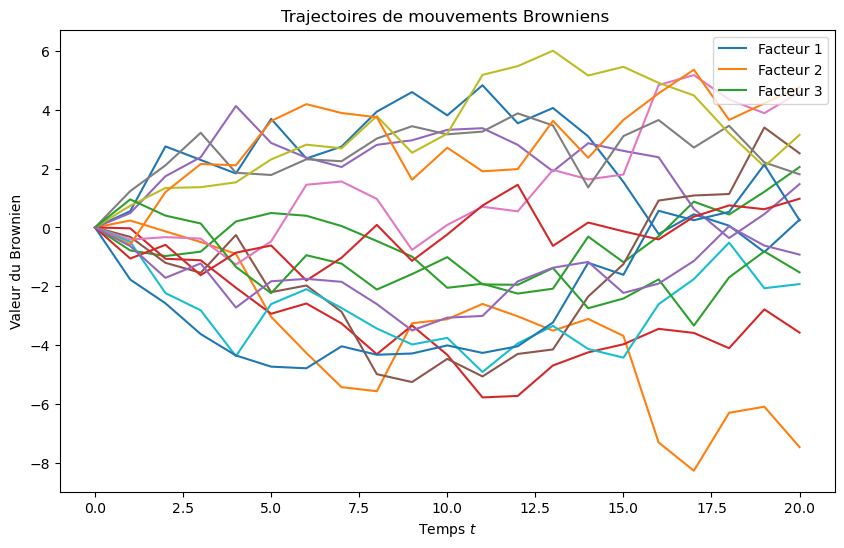

In [31]:
indices = np.random.choice(brownians.shape[0], 5, replace=False)

plt.figure(figsize=(10, 6))
for i in range(3):  # Pour chaque facteur
    for idx in indices:
        plt.plot(brownians[idx, :, i])  
plt.title("Trajectoires de mouvements Browniens ")
plt.xlabel("Temps $t$")
plt.ylabel("Valeur du Brownien")
plt.legend(['Facteur 1', 'Facteur 2', 'Facteur 3'], loc='upper right')
plt.show()

Pour vérifier qu'un s'agit bien de mouvements browniens, on vérifie que leurs incréments sont bien centrés et de variance constante.

In [32]:
mean_increments = np.mean(brownian_increments, axis=(0, 1))  # Moyenne sur toutes les simulations et tous les temps
variance_increments = np.var(brownian_increments, axis=(0, 1))  # Variance sur toutes les simulations et tous les temps


mean_of_means = np.mean(mean_increments)
var_of_means = np.var(mean_increments)
mean_of_variances = np.mean(variance_increments)
var_of_variances = np.mean(variance_increments)


print("Moyenne des moyennes d'incréments :", mean_of_means)
print("Moyenne des variances d'incréments :", mean_of_variances)
print("Variance des moyennes d'incréments :", var_of_means)
print("Variance des variances d'incréments :", var_of_variances)

Moyenne des moyennes d'incréments : -0.0008746565949719651
Moyenne des variances d'incréments : 0.9524649397758814
Variance des moyennes d'incréments : 6.83952323162348e-06
Variance des variances d'incréments : 0.9524649397758814


C'est bien le cas on a donc bien à faire à des mouvements browniens.

## <ins>Simulation</ins>

Nous allons à présent utiliser les mouvements Brownens générés pour simuler des trajectoires de taux et d'actions. 
 
1) <ins> Simulation des taux </ins>

D'après la question 1, nous pouvons écrire le schéma récursif suivant permettant de simuler des trajectoires de taux court : entre deux dates de simulations $t$ et $t'=t+\delta_{\text{simu}}$, nous avons 
$$
x\left(t_k\right)=x\left(t_{k-1}\right)e^{-a_1\left(t_k-t_{k-1}\right)}+\sigma_1 e^{-a_1t_k}\left(\int_{t_{k-1\ }}^{t_k}{e^{a_1u}dW^1_u}+\int_{t_{k-1\ }}^{t_k}{e^{a_1u}\gamma_1(u)du}\right) = x\left(t_{k-1}\right)e^{-a_1\left(t_k-t_{k-1}\right)}+\sigma_1 e^{-a_1t_k}\int_{t_{k-1\ }}^{t_k}{e^{a_1u}\gamma_1(u)du}+\sigma_1 e^{-a_1t_k}\sqrt{\frac{e^{2a_1t_k}-e^{2a_1t_{k-1}}}{2a_1}} G^{(1)}_{k}, 
$$

$$
y\left(t_k\right)=y\left(t_{k-1}\right)e^{-a_2\left(t_k-t_{k-1}\right)}+\sigma_2 e^{-a_2t_k}\left(\int_{t_{k-1}}^{t}{e^{a_2u}dW^2_u}+\int_{t_{k-1\ }}^{t_k}{e^{a_2u}\gamma_2(u)du}\right)\  = \ y\left(t_{k-1}\right)e^{-a_2\left(t_k-t_{k-1}\right)}+\sigma_2 e^{-a_2t_k}\int_{t_{k-1\ }}^{t_k}{e^{a_2u}\gamma_2(u)du}+\sigma_2 e^{-a_2t_k}\sqrt{\frac{e^{2a_2t_k}-e^{2a_2t_{k-1}}}{2a_2}}G^{(2)}_{k},
$$

Où $(G^{(1)}_{k}, G^{(2)}_{k})_{k=1, \dots, h \times \delta_{simu} }$ est une suite i.i.d de vecteurs gaussiens centrés et de matrice de corrélation :
$$
\begin{bmatrix} 
1 & \rho  \\ 
\rho & 1   
\end{bmatrix}
$$

Puis donc:

$$
r(t_k) = x(t_k) + y(t_k) + \varphi(t_k), 
$$

Finalement, en appliquant les formules de spécification du modèle données en introduction, on peut en déduire un schéma de simulation pour les prix zéro-coupon ainsi que l'indice "cash", défini dans l'énoncé tel que : 

$$
Cash_t = e^{\int_0^t r_u \text{d}u} 
$$

2) <ins> Simulation de l'action </ins>

L'application du lemme d'Ito à la dynamique du modèle BSDV nous donne la relation suivante : 
$$
S_{t} = S_0 \exp \left( \left( \mu - \frac{1}{2}\sigma^2 \right)t + \sigma B_t  \right)
$$
Nous fixerons $S_0=1$.

-----------------------------------------------------------------------------------------------------------------------------

### Question 13 (2 pts)

Le schéma de discrétisation des prix zéro-coupon et de l'indice "Cash" sont fournis.

**Implémenter** le schéma de discrétisation de l'action en utilisant les mouvements browniens `brownians[:, :, 2]` qui ont générés précédemment. En sortie de la simulation, on doit disposer d'une matrice de taille $\big(N_S, \frac{h}{\delta_{\text{simu}}}+1\big)$ contenant les $N_S$ simulations aux $\frac{h}{\delta_{\text{simu}}}$ dates de simulations (en commençant par la date 0). 

**Tracer** quelques trajectoires de l'indice "Cash" ainsi que de l'indice "Action".

-----------------------------------------------------------------------------------------------------------------------------

In [33]:
# Simulation des taux 
# Charger les donnees
spot_tab = donnees_marche['ZCR']
# Transformer les données en float
spot_tab_values = spot_tab.values
spot_tab_mat = spot_tab.index

#Calcul des prix ZC
spot_price = 1/((1+spot_tab_values)**spot_tab_mat)

#n_mat = spot_tab.shape[0]
driver_export = np.arange(1, M+1).astype(float)
n_mat = driver_export.shape[0]

x = np.zeros((h * p_y + 1, n_s))
y = np.zeros((h * p_y + 1, n_s))
zc_prices = np.full((h * p_y + 1, n_mat, n_s), np.nan)

zc_prices[0, :, :] = np.transpose(np.tile(spot_price[range(M)], (n_s, 1)))
zc_prices_stock = zc_prices
Cash_diff = np.ones((h * p_y + 1, n_s))


a_1 = param_calib_rel_g2pp[0]
a_2 = param_calib_rel_g2pp[1]
sigma_1 = param_calib_rel_g2pp[2]
sigma_2 = param_calib_rel_g2pp[3]
rho = param_calib_rel_g2pp[4]

# variables auxiliaires

sd_1 = sigma_1 * np.sqrt(compute_B(1 / p_y, 2 * a_1))
sd_2 = sigma_2 * np.sqrt(compute_B(1 / p_y, 2 * a_2))

gamma = rho * compute_B(1 / p_y, a_1 + a_2) * (sigma_1 * sigma_2) / (sd_1 * sd_2)

mu_1 = sigma_1 * compute_B(1 / p_y, a_1)
mu_2 = sigma_2 * compute_B(1 / p_y, a_2)

# schema de discretisation

for i in range(h * p_y):
    G1_incr = brownian_increments[:,i,0] * p_y
    G2_incr = brownian_increments[:,i,1] * p_y
    
    x[i + 1, :] = x[i, :] * np.exp(-a_1 / p_y) + mu_1 * gamma_1 + sd_1 * G1_incr 
    y[i + 1, :] = y[i, :] * np.exp(-a_2 / p_y) + mu_2 * gamma_2 + sd_2 * G2_incr
    # (
    #     gamma * G1_incr + np.sqrt(1 - gamma ** 2) * G2_incr
    # )


for i in range(h * p_y):


    term = i / p_y
    term_vec = term + driver_export

    idx_retained = np.where(spot_tab_mat.isin([term- 1+1]))[0]
    idx_retained_2 =  np.where(spot_tab_mat.isin([term+1]))[0]
    idx_retained_3 = np.where(spot_tab_mat.isin(term_vec+1))[0]
    spot_tab_values_repeate_2 = np.tile(spot_price[idx_retained_2], len(spot_price[idx_retained_3]))

    zc_prices_ratio_1 = spot_price[idx_retained_3]/spot_tab_values_repeate_2
    if i == 0:
        zc_prices_ratio_2 = spot_price[idx_retained_2]
    else:
        spot_tab_values_repeated = np.tile(spot_price[idx_retained], len(spot_price[idx_retained_2]))
        zc_prices_ratio_2 =  spot_price[idx_retained_2]/spot_tab_values_repeated
       


    V_0_term = compute_A(term, param_calib_rel_g2pp)
    A =(0.5 * (compute_A(term_vec - term, param_calib_rel_g2pp) - compute_A(term_vec, param_calib_rel_g2pp) + V_0_term)
     - ((1 - np.exp(-a_1 * driver_export)) / a_1) * np.transpose(np.tile(x[int(term * p_y + 1), :], (n_mat, 1)))
     - ((1 - np.exp(-a_2 * driver_export)) / a_2) * np.transpose(np.tile(y[int(term * p_y + 1), :], (n_mat, 1)))
     )


    zc_prices_ratio_1_extended = np.tile(zc_prices_ratio_1, (A.shape[0], 1))
    zc_prices[i + 1, :, :] = np.transpose(zc_prices_ratio_1_extended * np.exp(A))
    exp_int_phi = zc_prices_ratio_2 * np.exp(-0.5 * (V_0_term - compute_A(term - 1 / p_y, param_calib_rel_g2pp) ))
    Cash_diff[i+1,:] = Cash_diff[i,:]/exp_int_phi*np.exp((0.5/p_y*(x[i,:]+x[i+1,:]+y[i,:]+y[i+1,:])))



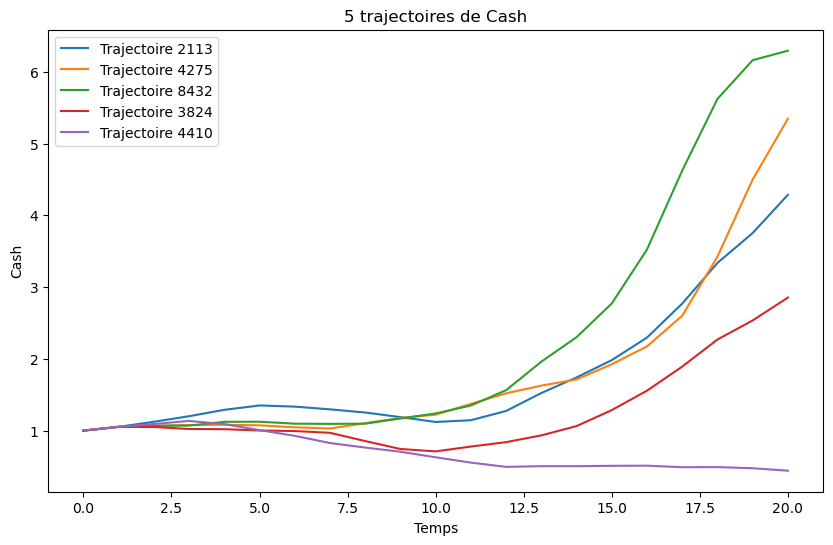

In [34]:
plt.figure(figsize=(10, 6))

# Sélection aléatoire de 5 trajectoires
indices = np.random.choice(brownians.shape[0], 5, replace=False)

for i in indices:  #
    plt.plot(Cash_diff[:, i], label=f'Trajectoire {i+1}')

plt.title("5 trajectoires de Cash")
plt.xlabel("Temps")
plt.ylabel("Cash")
plt.legend()
plt.show()

In [35]:
#Simulation de l'indice action

delta = 1/12
sigma_squared = v_hat / delta
sigma = np.sqrt(sigma_squared)
mu = m_hat / delta + v_hat / 2

# Initialisation de la matrice pour les simulations de l'action
S = np.zeros((n_s, int(h/delta_simu) + 1))
S[:, 0] = 1  # On initialise S_0 à 1 pour toutes les simulations

# Simulation des trajectoires de l'action
for i in range(1, int(h/delta_simu) + 1):
    t = i * delta_simu  # Le temps t à l'étape i
    S[:, i] = S[:, 0] * np.exp((mu - 0.5 * sigma**2) * t + sigma * brownians[:, i, 2])

S=np.transpose(S)

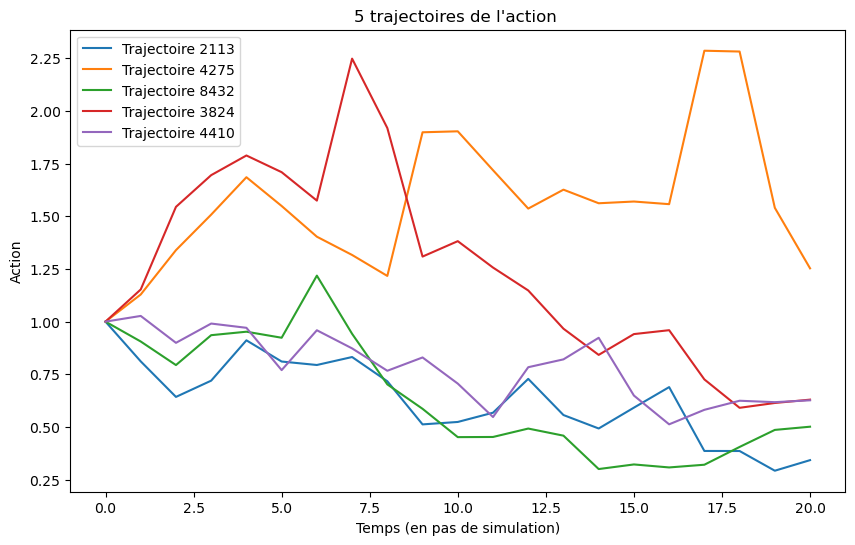

In [36]:
plt.figure(figsize=(10, 6))

# Sélection aléatoire de 5 trajectoires
indices_selectionnes = np.random.choice(brownians.shape[0], 5, replace=False)

for i in indices:  
    plt.plot(S[:, i], label=f'Trajectoire {i+1}')

plt.title("5 trajectoires de l'action ")
plt.xlabel("Temps (en pas de simulation)")
plt.ylabel("Action")
plt.legend()
plt.show()

## <ins>Validation</ins>

Les trajectoires étant simulées (annuellement), nous souhaitons à présent vérifier qu'elles sont cohérentes avec les données utilisées pour calibrer les modèles et qu'elles repectent certaines propriétés théoriques. Le but de cette partie est vérifier que les trajectoires simulées des prix zéro-coupons et actions ont bien une  distribution cohérente avec les cibles de moyenne, volatilité et dispersion utilisées pour le calibrage des paramètres. 

-----------------------------------------------------------------------------------------------------------------------------

### Question 14 (2.5 pts)

**Mettre** en oeuvre un test de validation sur les prix zéro-coupons qui vérifie la distribution empirique des trajectoires simulées, pour cela on pourra examiner les quantités suivantes : 

$\frac{1}{N} \sum_{n=1}^{N} \mathbb{D}isp\left( m_l \right)^{(n)} - \widehat{d}$
et
$\frac{1}{N} \sum_{t=1}^{N} \mathbb{V}ol \left(m_l \right)^{(n)} - \widehat{v}$ pour $m_l = \{1,10\}$

où :
* $N$ représente le nombre de simulations ; 
* $H$ l'horizon de projection ;
* $\widehat{m}$ et $\widehat{v}$ les cibles distributionnelles historiques de l'action définie comme à la question 7.
* $R^{(n)} (t , t + m_l)$ la valeur du taux zéro-coupons simulé dans la trajectoire $n$ entre le moment ; 
* $mean(m_l)^{(n)} = \frac{1}{H} \sum_{t=1}^{H} R^{(n)} (t , t + m_l)$
* $\mathbb{D}isp\left( m_l \right)^{(n)} = \frac{1}{H-1} \sum_{t=1}^{H}  \left( R^{(n)} (t , t + m_l) - mean(m_l)\right)^2$ ;

* $\mathbb{V}ol \left(m_l \right)^{(n)} = \frac{1}{H-2} \sum_{t=1}^{H}  \left( X^{(n)} (t , t + m_l) - \frac{1}{H-1}  \sum_{t=1}^{H-1} X^{(n)} (t , t + m_l)\right)^2$; 

où : 
* $X^{(n)} (t , t + m_l) = R^{(n)} (t+1 , t+1 + m_l) - R^{(n)} (t , t + m_l)$

**Commenter et expliquer** pourquoi on ne retrouve pas exactement des quantitées nulles.

-----------------------------------------------------------------------------------------------------------------------------

In [37]:
h = 20
n_s = 10000
n_f = 3
p_y = 1
delta_simu = int(1/p_y)
M = 30
N = n_s  # Nombre de simulations
H = h  # Horizon de projection en termes de nombre de pas de temps
ml = [1, 10]  # Maturités pour lesquelles faire le test

# Calcul des taux zéro-coupons pour les maturités ml = {1, 10}
R = {m: np.log(zc_prices[:-m, m-1, :]) - np.log(zc_prices[m:, m-1, :]) for m in ml}

# Initialisation des structures pour stocker les résultats
disp = {m: np.zeros(N) for m in ml}
vol = {m: np.zeros(N) for m in ml}

# Boucle sur chaque maturité ml
for m in ml:
    for n in range(N):
        mean_ml = R[m][:, n].mean()
        disp[m][n] = np.sum((R[m][:, n] - mean_ml) ** 2) / (H - 1)
        vol[m][n] = np.sum(np.diff(R[m][:, n]) ** 2) / (H - 2)

# Calcul des moyennes des dispersions et volatilités
disp_mean = {m: np.mean(disp[m]) for m in ml}
vol_mean = {m: np.mean(vol[m]) for m in ml}



# Calcul des écarts par rapport aux cibles historiques
disp_diff = {m: disp_mean[m] - m_hat for m in ml}
vol_diff = {m: vol_mean[m] - v_hat for m in ml}

disp_diff, vol_diff

({1: -0.002129306709814754, 10: 0.09135723450494132},
 {1: 0.0022103799350257306, 10: 0.0559598785830322})

Les valeurs sont très faibles ce qui confirme la bonne exécution du calcul. Il est normal de ne pas trouver des quantités exactement nulles car on fait des simulations aléatoires.

-----------------------------------------------------------------------------------------------------------------------------
### Question 15 (1.5 pt)

Mettre en oeuvre un test de validation sur l'action qui vérifie la distribution empirique des trajectoires simulées, pour cela on pourra examiner les quantités suivantes : 

$\frac{1}{N} \sum_{n=1}^{N} \overline{X^{(n)}} - \frac{\widehat{m}}{\delta_{hist}}$
et
$\frac{1}{N} \sum_{t=1}^{N} \mathbb{V}\left( X^{(n)} \right) - \frac{\widehat{v}}{\delta_{hist}}$

où :
* $N$ représente le nombre de simulations ; 
* $H$ l'horizon de projection ;
* $\overline{X^{(n)}} = \frac{1}{H \delta_{simu}} \sum_{t=1}^{H-1} ln \left( \frac{S_{t+\delta}^{(n)}}{S_t^{(n)}} \right)$ ; 
* $\mathbb{V}\left(X^{(n)} \right) = \frac{1}{(H-2)\delta_{simu}} \sum_{t=1}^{H-1}  \left(ln \left( \frac{S_{t+\delta}^{(n)}}{S_t^{(n)}} \right) - \overline{X^{(n)}}   \right)^2$ ; 
* $S_t^{(n)}$ la valeur de l'indice action simulé dans la trajectoire $n$ ; 
* $\widehat{m}$ et $\widehat{v}$ les cibles distributionnelles historiques de l'action définie comme à la question 7.

**Commenter et expliquer** pourquoi on ne retrouve pas exactement des quantitées nulles.


-----------------------------------------------------------------------------------------------------------------------------

In [38]:
# Données historiques des log-rendements
historical_log_returns = log_returns

# Cibles historiques de moyenne et variance des log-rendements
m_hat = np.mean(historical_log_returns)
v_hat = np.var(historical_log_returns)

# Trajectoires simulées des prix des actions
S_simulated = S

# Calcul des log-rendements pour chaque trajectoire simulée
log_returns = np.log(S_simulated[1:] / S_simulated[:-1])

# Calcul des moyennes et variances des log-rendements pour chaque trajectoire simulée
mean_log_returns = np.mean(log_returns, axis=0)
var_log_returns = np.var(log_returns, axis=0)

# Calcul des écarts par rapport aux cibles historiques
mean_diff = np.mean(mean_log_returns) - (m_hat / delta_histo)
var_diff = np.mean(var_log_returns) - (v_hat / delta_histo)

# Affichage des résultats
print("Moyenne empirique historique des log-rendements:", m_hat)
print("Variance empirique historique des log-rendements:", v_hat)
print("Écart moyen par rapport à la moyenne historique:", mean_diff)
print("Écart moyen par rapport à la variance historique:", var_diff)


Moyenne empirique historique des log-rendements: 0.00456600840614905
Variance empirique historique des log-rendements: 0.0032369159174981668
Écart moyen par rapport à la moyenne historique: -0.018444175012652754
Écart moyen par rapport à la variance historique: -0.0017546371767674027




-----------------------------------------------------------------------------------------------------------------------------
### Question 16 (1 pt)

**Reprendre** les questions précédentes en faisant varier le nombre de simulations $N_S$. Comment évoluent les résultats ? 

-----------------------------------------------------------------------------------------------------------------------------

## <ins>Calcul d'allocation du portefeuille</ins>

### Question 17 (2 pts)

**Utiliser** les trajectoires d'action et de prix Zéro-Coupon simulées précédemment pour **calculer** une allocation optimale du portefeuille à horizon 5 ans en fixant premièrement comme critère le ratio de Sharp défini comme tel :


$$
S = \frac{\mathbb{E}\left( P_t \right)}{\sqrt{\mathbb{V}\left( P_t \right)}}
$$

Pour cela, **utiliser et completer** le code suivant. Decrivez également son fonctionnement et son objectif. 


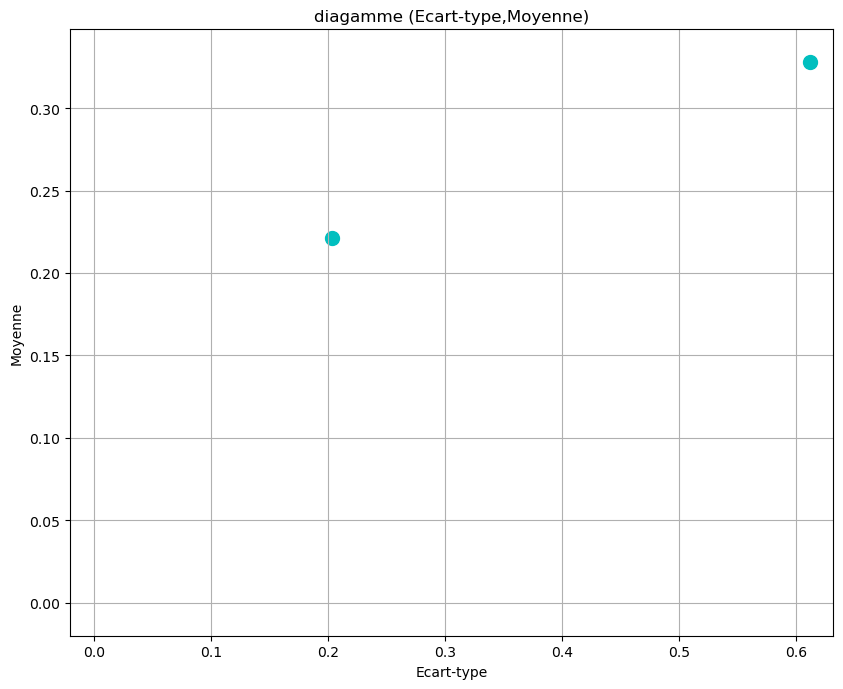

In [39]:
# Définir l'horizon auquel on fait l'etude d'allocation d'actif
T = 5

St_diff = S 
Cash_diff = Cash_diff

S_t = St_diff[T*delta_simu, :]
P_t = Cash_diff[T*delta_simu, :]

# Concaténer les vecteurs en une matrice de taille N*2
simu = np.column_stack((S_t, P_t))

# On choisit les variances des actifs
sigma = [np.sqrt(S_t.var()),np.sqrt(P_t.var())]
mu = [S_t.mean()-1,P_t.mean()-1]

# plot ###################################################################
max_sigma=max(sigma)
max_esp=max(mu)
marge=0.02
un_inche_en_cm=2.54 # 1 inche = 2.54 cm

taille_h_cm=25
taille_v_cm=20

marker_size=100

def plot1():
    # On crée un figure dont on fixe la taille et dont on définit les axes
    fig = plt.gcf()
    fig.set_size_inches(taille_h_cm/un_inche_en_cm,taille_v_cm/un_inche_en_cm)
    plt.axis([-marge, max_sigma+marge, -marge, max_esp+marge])
    # On trace les points représentant les 2 actifs.
    plt.scatter(sigma,mu, s=marker_size, c='c',marker='o')
    plt.ylabel('Moyenne')
    plt.xlabel('Ecart-type')
    plt.title('Diagamme Ecart-type/Moyenne)')
    #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
    plt.grid(True)

plot1();

Les poids optimal est : 
0.18000000000000002


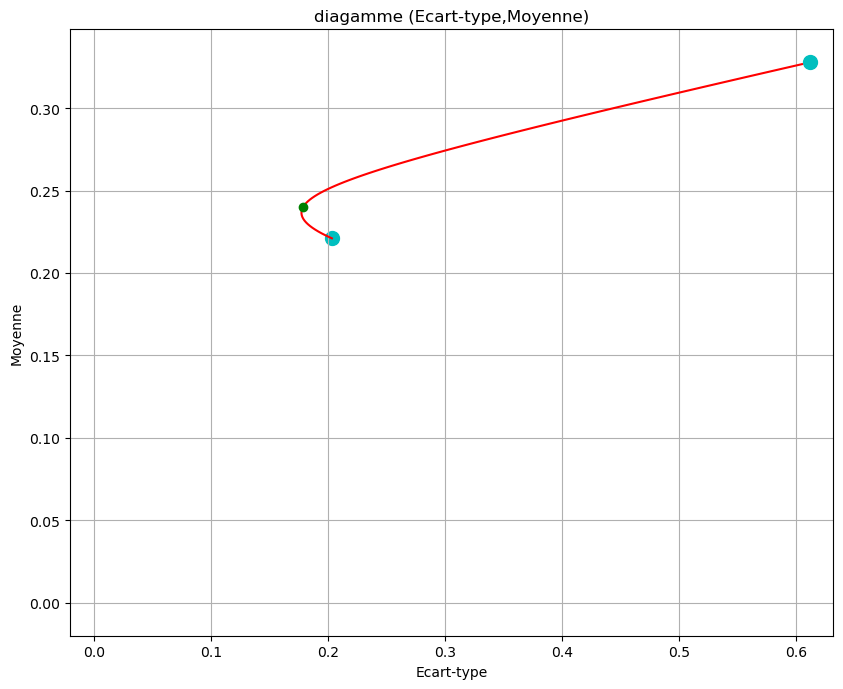

In [47]:
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

N=100;
moyenne_x=np.zeros(N)
std_x=np.zeros(N)
sharp = np.zeros(N)
alpha = np.zeros(N)
rdt = 0
i=0
for x_1 in frange(0.0,1.0,1.0/N):
    current_x = [x_1,1-x_1]  # composition du portefeuille  x_1 + x_2 = 1
    alpha[i] = x_1
    rdt = np.dot(simu,current_x)
    moyenne_x[i] = rdt.mean()-1  #calcul de la moyenne du rendement du porfefeuille
    std_x[i]= np.sqrt(rdt.var()) # A COMPLETER calcul de son écart-type
    sharp[i] = moyenne_x[i] / std_x[i]
    
    i=i+1
      
# plot ###################################################################
def plot2():
    plot1()# le plot précédent
    plt.plot(std_x,moyenne_x, 'r-')
    
plot2()

# Trouvez l'index où Z a la valeur maximale
idx_max = np.argmax(sharp) # A COMPLETER

# Ajoutez le point rouge au plot
plt.plot(std_x[idx_max], moyenne_x[idx_max], 'go')

print("Les poids optimal est : ")
print(alpha[idx_max])

### Question 18 (1 pt)

A présent, déterminer le poids $\alpha$ optimal de telle façon à ce que le quantile $95\%$ des valeurs du portefeuille soit supérieur à 2.4, tout en maximisant le ratio de Sharp. Commentez la position du nouveau portefeuille optimal par rapport à celle obtenue à la question précédente. 




Les poids optimal est : 
0.9600000000000006


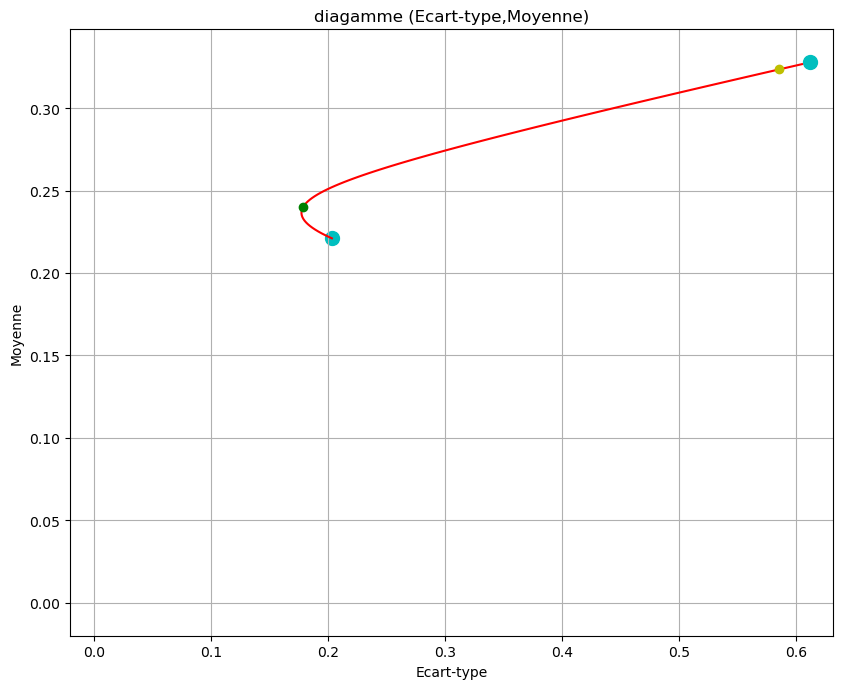

In [43]:
####################
quantile_alpha = 0.95
seuil_quantile_objectif_rdt = 2.4

moyenne_x=np.zeros(N)
std_x=np.zeros(N)
sharp = np.zeros(N)
alpha = np.zeros(N)
quantile = np.zeros(N)
rdt = 0
i=0

for x_1 in frange(0.0,1.0,1.0/N):
    current_x = [x_1,1-x_1]  # composition du portefeuille  x_1 + x_2 = 1
    alpha[i] = x_1
    
    ######  A vous de jouer  
    rdt = np.dot(simu,current_x)
    moyenne_x[i] = rdt.mean()-1  #calcul de la moyenne du rendement du porfefeuille
    quantile[i] = np.quantile(rdt,quantile_alpha)
    std_x[i]=  np.sqrt(rdt.var()) 
    sharp[i] = moyenne_x[i] / std_x[i]

    if quantile[i] < seuil_quantile_objectif_rdt:
        sharp[i] = 0
    
    i=i+1
    
# plot ###################################################################
def plot2():
    plot1()# le plot précédent
    plt.plot(std_x,moyenne_x, 'r-')
    
plot2()

# Trouvez l'index où sharp a la valeur maximale
idx_max_quant = np.argmax(sharp) 

# Ajoutez le point rouge au plot
plt.plot(std_x[idx_max], moyenne_x[idx_max], 'go')
plt.plot(std_x[idx_max_quant], moyenne_x[idx_max_quant], 'yo')

print("Les poids optimal est : ")
print(alpha[idx_max_quant])

Le nouveau portefeuille se situe aussi dans la frontière efficiente, il a un risque plus élevé et son rendement est aussi plus élevé. C'est normal car il donne un plus gros poids à l'actif le plus risque qui est l'action.